# Fitting cosmological parameters with the Core Cosmological Library (CCL)#

This notebook shows how to fit cosmological parameters using CCL and measurements of cosmic shear correlation functions ($\xi_\pm$). Currently it uses analytical forms for the photometric redshift count histograms, $n(z)$ and simulates data based on the correlation functions computed by CCL. Replacing [$n(z)$](#nz) and [$\xi_\pm^{ij}$](#datasets) with real data should be straight forward.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pylab as plt
from matplotlib import gridspec
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact
import itertools
import pyccl as ccl
import os
import scipy.stats as st
from iminuit import Minuit
from iminuit.util import describe, make_func_code
from iminuit.cost import Cost

%matplotlib inline

`Cosmo` class by Pierre-Francois Leget. Reparametrizes cosmological parameters to be non-degenerate for cosmic shear measurements.

In [3]:
class Cosmo:
    def __init__(self,Omega_ch2=0.1, Omega_bh2=0.023, AS=None, S8=None,
                 Omega_nu_h2=0., H0=70, ns=0.97, w0=-1, alpha=0.45, 
                 matter_power_spectrum = 'halofit'):
        
        self._matter_power_spectrum =  matter_power_spectrum
        self.update_cosmology(Omega_ch2=Omega_ch2, Omega_bh2=Omega_bh2,
                              AS=AS, S8=S8, alpha=alpha,
                              Omega_nu_h2=Omega_nu_h2,
                              H0=H0, ns=ns, w0=w0)
        
    def update_cosmology(self, Omega_ch2=0.1, Omega_bh2=0.023, AS=None, S8=None,
                         Omega_nu_h2=1e-3, H0=70, ns=0.97, w0=-1, alpha=0.45):

        self.Omega_ch2 = Omega_ch2
        self.Omega_bh2 = Omega_bh2
        self.H0 = H0
        self._h = self.H0 / 100.

        self._Omega_b = self.Omega_bh2 / self._h**2
        self._Omega_c = self.Omega_ch2 / self._h**2
        self._Omega_m = self._Omega_b + self._Omega_c
        self.Omega_nu_h2 = Omega_nu_h2
        self._m_nu = (self.Omega_nu_h2 / self._h**2) * 93.14

        if S8 is None and AS is None:
            raise ValueError('S8 or AS should be given')
        if S8 is not None and AS is not None:
            raise ValueError('Just S8 or AS should be given')

        if S8 is not None:
            self.AS = None
            self._A_s = None
            self._sigma8 = S8 * (1./ (self._Omega_m/0.3)**alpha)
        if AS is not None:
            self.AS = AS
            self._A_s = np.exp(self.AS) * 1e-10
            self._sigma8 = None

        self.n_s = ns
        self.w0 = w0

        self.cosmology = ccl.Cosmology(Omega_c=self._Omega_c, Omega_b=self._Omega_b,
                                       h=self._h, n_s=self.n_s, sigma8=self._sigma8, A_s=self._A_s,
                                       w0=self.w0, m_nu=self._m_nu,
                                       matter_power_spectrum=self._matter_power_spectrum)

C = Cosmo(Omega_ch2=0.1, Omega_bh2=0.023, AS=4.,
          Omega_nu_h2=1e-3, H0=70, ns=0.97, w0=-1,
          matter_power_spectrum = 'halofit')

In [4]:
C.cosmology

pyccl.Cosmology(Omega_c=0.20408163265306126, Omega_b=0.04693877551020409, h=0.7, n_s=0.97, sigma8=None, A_s=5.459815003314424e-09, Omega_k=0.0, Omega_g=None, Neff=3.046, w0=-1, wa=0.0, T_CMB=None, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, mu_0=0.0, sigma_0=0.0, m_nu=0.19008163265306124, m_nu_type=None, z_mg=None, df_mg=None, transfer_function='boltzmann_camb', matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker10', halo_concentration='duffy2008', emulator_neutrinos='strict')

In [5]:
@interact(Om = widgets.FloatSlider(value=0.9, min=0.01, max=0.99, step=0.01, description='$\Omega_m$:',
          disabled=False,
          continuous_update=False,
          orientation='horizontal'),
          w = widgets.FloatSlider(value=-1., min=-2, max=-0.3, step=0.01, description='$w$:',
          disabled=False,
          continuous_update=False,
          orientation='horizontal',
          readout=True,
          readout_format='.2f'))
def distance_modulus(Om, w):
          
    C = Cosmo(Omega_ch2=Om*0.7*0.7, Omega_bh2=0.0, AS=4.,
              Omega_nu_h2=0., H0=70, ns=0.97, w0=w,
              matter_power_spectrum = 'halofit')
    z = np.linspace(0.01, 1.2, 200)
    plt.figure(figsize=(10,6))
    plt.plot(z, ccl.distance_modulus(C.cosmology, 1/(1+z)))
    plt.xlabel('z',fontsize=18)
    plt.ylabel('$\mu$', fontsize=18)
    plt.ylim(32,45)
    plt.xlim(0.01,1.2)
    #plt.xscale('log')

interactive(children=(FloatSlider(value=0.9, continuous_update=False, description='$\\Omega_m$:', max=0.99, mi…

<a id='nz'></a>

All weak lensing tracers use the following analytic Gaussian redshift bins. Note `redshifts` and `nz` are global variables.

In [6]:
key = '_hamana'

redshifts = []
nz = []

# for i in range(4):
#     file_bin = np.loadtxt(os.path.join('', '../Analysis/shear_subaru/shear_subaru/data/photo-z/bin%i'%(i+1))+key+'.dat', comments='#')
#     redshifts.append(file_bin[:,0])
#     nz.append(file_bin[:,1])
    
for i in range(4):
    z_range = np.linspace(0, 2.6, 2600)
    nz_i = st.norm.pdf(z_range, (i+1)*0.4, 0.2)
    redshifts.append(z_range)
    nz.append(nz_i)

redshifts = np.array(redshifts)
nz_distros = np.array(nz)

@interact(dz1 = widgets.FloatSlider(value=0., min=-0.1, max=0.1, step=0.01, description='$\Delta z_1$:',
          disabled=False,
          continuous_update=False,
          orientation='horizontal'),
          dz2 = widgets.FloatSlider(value=0., min=-0.1, max=0.1, step=0.01, description='$\Delta z_2$:',
          disabled=False,
          continuous_update=False,
          orientation='horizontal'),
          dz3 = widgets.FloatSlider(value=0., min=-0.1, max=0.1, step=0.01, description='$\Delta z_3$:',
          disabled=False,
          continuous_update=False,
          orientation='horizontal'),
          dz4 = widgets.FloatSlider(value=0., min=-0.1, max=0.1, step=0.01, description='$\Delta z_4$:',
          disabled=False,
          continuous_update=False,
          orientation='horizontal'))

def load_photo_z(dz1, dz2, dz3, dz4):
    
    DZ = [dz1, dz2, dz3, dz4]

 
    C = ['k', 'b', 'y', 'r']
    plt.figure(figsize=(12,4))
    for i in range(4):
        plt.plot(redshifts[i]-DZ[i], nz[i], C[i], lw=3)

    plt.plot([0,2.6], [0,0], 'k--')
    plt.xlabel('z', fontsize=18)
    plt.ylabel('N(z)', fontsize=18)
    plt.xlim(0,2.6)
    plt.ylim(-0.1,4.2)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='$\\Delta z_1$:', max=0.1, m…

Set up weak lensing tracers for each redshift bin as a demonstration. These instances don't actually get used for fitting.

In [7]:
def intrinsic_al(redshift, A0=1, eta=1, z0=0.62):
    AI = A0 * ((1+redshift) / (1+z0))**eta
    return AI

WL_bin1 = ccl.WeakLensingTracer(C.cosmology,
                                dndz=(redshifts[0], nz[0]),
                                has_shear=True,
                                ia_bias=(redshifts[0], intrinsic_al(redshifts[0])))

WL_bin2 = ccl.WeakLensingTracer(C.cosmology,
                                dndz=(redshifts[1], nz[1]),
                                has_shear=True,
                                ia_bias=(redshifts[1], intrinsic_al(redshifts[1])))

WL_bin3 = ccl.WeakLensingTracer(C.cosmology,
                                dndz=(redshifts[2], nz[2]),
                                has_shear=True,
                                ia_bias=(redshifts[2], intrinsic_al(redshifts[2])))

WL_bin4 = ccl.WeakLensingTracer(C.cosmology,
                                dndz=(redshifts[3], nz[3]),
                                has_shear=True,
                                ia_bias=(redshifts[3], intrinsic_al(redshifts[3])))


/home/yve/anaconda3/lib/python3.7/site-packages/pyccl/core.py:678: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  category=CCLWarning)


**Main model function**

In [9]:
def xi_pm_ij(theta, Om_ch2, AS, bin_i=1, bin_j=1, sign='+'):
    """
    Currently can fit for Om_ch2, AS
    bin_i, bin_j, and sign must be passed through the cost function: is
    there a better way to generalize this?
    """
    
    #set up cosmology to be fit
    #currently only fits for Omega_ch2 and AS
    C = Cosmo(Omega_ch2=Om_ch2, Omega_bh2=0.023, AS=AS,
          Omega_nu_h2=1e-3, H0=70, ns=0.97, w0=-1,
          matter_power_spectrum = 'halofit')
        
    #set up redshift and n(z) bins from (global variable) data
    bin_i_idx = int(bin_i - 1)
    bin_j_idx = int(bin_j - 1)
    
    z_i = redshifts[bin_i_idx]
    nz_i = nz_distros[bin_i_idx]
    
    z_j = redshifts[bin_j_idx]
    nz_j = nz_distros[bin_j_idx]
    
    AI_i = intrinsic_al(z_i, A0=1, eta=1, z0=0.62)
    AI_j = intrinsic_al(z_j, A0=1, eta=1, z0=0.62)

    #calculate WL bins
    WL_bin_i = ccl.WeakLensingTracer(C.cosmology,
                                    dndz=(z_i, nz_i),
                                    has_shear=True,
                                    ia_bias=(z_i, AI_i))
    
    WL_bin_j = ccl.WeakLensingTracer(C.cosmology,
                                    dndz=(z_j, nz_j),
                                    has_shear=True,
                                    ia_bias=(z_j, AI_j))
    
    #Calculate angular power spectrum
    ell = np.arange(1, 2000)
    Cl_ij = ccl.angular_cl(C.cosmology, WL_bin_i, WL_bin_j, ell)

    #calculate correlation function xi_plus_ij or xi_minus_ij
    if sign is '+':
        type_str = 'GG+'
    else:
        type_str = 'GG-'
    
    xi_pm_ij = ccl.correlation(C.cosmology, ell, Cl_ij, theta, type=type_str)
        
    return xi_pm_ij

**Preliminary cost function for data with no errors.**\
We will see this doesn't behave very well...

In [10]:
#adapted class from iminuit tutorial
class LeastSquaresNoErr(Cost):
    """
    Generic least-squares cost function without error.
    """

    errordef = Minuit.LEAST_SQUARES # for Minuit to compute errors correctly
    
    def __init__(self, model, x, y, bin_i=None, bin_j=None, sign=None):
        super().__init__(describe(model)[1:3], len(x), verbose=1)
        self.model = model  # model predicts y for given x
        self.x = np.asarray(x)
        self.y = np.asarray(y)
        self.bin_i = bin_i
        self.bin_j = bin_j
        self.sign = sign        
        
    def _call(self, *par):  # we accept a variable number of model parameters
        ym = self.model(self.x, bin_i = self.bin_i, bin_j = self.bin_j, sign=self.sign, *par[0])
        return np.sum((self.y - ym) ** 2)

Produce data for Xi_44_plus for testing model and cost functions

[0.01       0.01321621 0.01746681 0.0230845  0.03050896 0.04032127
 0.05328943 0.07042841 0.09307965 0.12301599 0.16258049 0.21486974
 0.2839763  0.37530897 0.49601611 0.65554518 0.8663821  1.14502854
 1.51329346 2.        ]
[1.26497980e-03 1.08198996e-03 8.35141989e-04 6.85813864e-04
 5.71411419e-04 4.53031465e-04 3.58824835e-04 2.83008319e-04
 2.24000639e-04 1.73857949e-04 1.36477365e-04 1.06419545e-04
 8.43355014e-05 6.48428212e-05 4.94962991e-05 3.64792684e-05
 2.59927845e-05 1.77515269e-05 1.14639622e-05 7.01201606e-06]
[1.24508444e-03 1.06244922e-03 8.33883646e-04 6.56326898e-04
 5.37946434e-04 3.86342065e-04 2.86361838e-04 1.92324382e-04
 1.75024084e-04 1.50738241e-04 7.73359467e-05 1.00036865e-04
 1.00597934e-04 6.71477904e-05 6.12940958e-05 1.46559103e-05
 6.72242664e-05 4.80827227e-05 2.47727250e-05 2.69657452e-05]


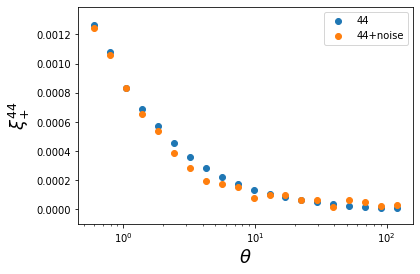

In [13]:
#get samples from xip_44
ell = np.arange(1, 2000)
theta_sample = np.logspace(-2, np.log10(2), 20)

Cl_44 = ccl.angular_cl(C.cosmology, WL_bin4, WL_bin4, ell)
xip_44_sample = ccl.correlation(C.cosmology, ell, Cl_44, theta_sample, type='GG+')
print(theta_sample)
print(xip_44_sample)

#add noise
noise = st.norm.rvs(0, 5e-5, size=len(xip_44_sample), random_state=1369)
noisy_44_sample = xip_44_sample + noise

print(noisy_44_sample)


plt.figure()
plt.scatter(60*theta_sample, xip_44_sample, label='44')
plt.scatter(60*theta_sample, noisy_44_sample, label='44+noise')
plt.xscale('log')
plt.xlabel('$\\theta$', fontsize=18)
plt.ylabel('$\\xi_{+}^{44}$', fontsize=18)
plt.ylim(-0.0001, np.max(xip_44_sample)+0.1*np.max(xip_44_sample))
plt.legend()

In [14]:
#Testing Least-Squares with no error on Xi_plus_44 correlation "data" with no errors/noise.
lsq_no_err = LeastSquaresNoErr(xi_pm_ij, theta_sample, xip_44_sample, 4, 4, '+')

#input cosmology for reference
#C = Cosmo(Omega_ch2=0.1, Omega_bh2=0.023, AS=4.,
#          Omega_nu_h2=0, H0=70, ns=0.97, w0=-1,
#          matter_power_spectrum = 'halofit')

m = Minuit(lsq_no_err, Om_ch2=0.11, AS=4.1)
m.params

m.limits['Om_ch2'] = (0.03, 0.7)
m.limits['AS'] = (1.5, 6)

m.migrad()

/home/yve/anaconda3/lib/python3.7/site-packages/pyccl/core.py:678: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  category=CCLWarning)


(0.11, 4.1) -> 9.615693205979357e-07
(0.11001100056812463, 4.1) -> 9.630713505436213e-07
(0.10998900008561167, 4.1) -> 9.600614421028891e-07
(0.1101100350947261, 4.1) -> 9.76717007456227e-07
(0.1098900302789028, 4.1) -> 9.465520240283481e-07
(0.11, 4.100410019028989) -> 9.646539352302415e-07
(0.11, 4.09958996905964) -> 9.584858183309847e-07
(0.11, 4.104099651975943) -> 9.926894072683983e-07
(0.11, 4.095899156887319) -> 9.310511002884736e-07
(0.0977203098515072, 3.8887943788536568) -> 1.7326183940844607e-07
(0.10184900785550792, 3.961786085413682) -> 7.0293272584777046e-12
(0.10290203257523899, 3.961786085413682) -> 3.58981844194326e-09
(0.10080272944907666, 3.961786085413682) -> 3.750774686608308e-09
(0.11053326952479277, 3.961786085413682) -> 2.686794294939977e-07
(0.09360366882419376, 3.961786085413682) -> 2.0850185989391915e-07
(0.10184900785550792, 4.003071184397388) -> 1.42027789435516e-08
(0.10184900785550792, 3.9204289124002787) -> 1.3543421452387467e-08
(0.10184900785550792, 4.

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 7.029e-12 (chi2/ndof = 0.0)│              Nfcn = 33               │
│ EDM = 8.93e-13 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Om_ch2 │    0.1    │    0.5    │            │            │  0.03   │   0.7   │       │
│ 1 │ AS     │    4.0    │    3.2    │            │            │   1.5   │    6    │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────┐
│        │    Om_ch2        AS │
├────────┼─────────────────────┤
│ Om_ch2 │  5.83e+04 -1.17e+06 │
│     AS │ -1.17e+06  2.36e+07 │
└────────┴─────────────────────┘

In [15]:
print(m.valid, m.accurate)

True False


/home/yve/anaconda3/lib/python3.7/site-packages/pyccl/core.py:678: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  category=CCLWarning)


(0.03, 3.961786085413682) -> 4.62587512402341e-06
(0.06, 3.961786085413682) -> 3.1172422760794653e-06
(0.09, 3.961786085413682) -> 4.116701750324443e-07
(0.12, 3.961786085413682) -> 1.2495350475422523e-06
(0.15, 3.961786085413682) -> 9.605270005389565e-06
(0.18, 3.961786085413682) -> 2.4918773597943558e-05
(0.21, 3.961786085413682) -> 4.5118956854748054e-05
(0.24, 3.961786085413682) -> 7.041428898180388e-05
(0.27, 3.961786085413682) -> 0.00010477136958965989
(0.30000000000000004, 3.961786085413682) -> 0.00015543211515105555
(0.32999999999999996, 3.961786085413682) -> 0.00023164449935829542
(0.36, 3.961786085413682) -> 0.0003430106290372603
(0.39, 3.961786085413682) -> 0.0004981821609892959
(0.42000000000000004, 3.961786085413682) -> 0.0007047591361328107
(0.44999999999999996, 3.961786085413682) -> 0.000968567835247337
(0.48, 3.961786085413682) -> 0.0012926115604583977
(0.51, 3.961786085413682) -> 0.0016760621947261394
(0.54, 3.961786085413682) -> 0.002116710748071776
(0.570000000000000

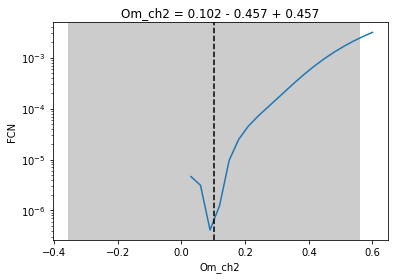

In [16]:
m.draw_profile('Om_ch2', bound=(0.03, 0.6), size=20)
plt.yscale('log')

/home/yve/anaconda3/lib/python3.7/site-packages/pyccl/core.py:678: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  category=CCLWarning)


(0.10184900785550792, 1.5) -> 4.4939063199040645e-06
(0.10184900785550792, 1.736842105263158) -> 4.382798365213504e-06
(0.10184900785550792, 1.9736842105263157) -> 4.228370253211143e-06
(0.10184900785550792, 2.2105263157894735) -> 4.014570952915644e-06
(0.10184900785550792, 2.4473684210526314) -> 3.7212068648387604e-06
(0.10184900785550792, 2.6842105263157894) -> 3.3250807607600353e-06
(0.10184900785550792, 2.9210526315789473) -> 2.804421396113948e-06
(0.10184900785550792, 3.1578947368421053) -> 2.1498054836313337e-06
(0.10184900785550792, 3.394736842105263) -> 1.3863396387635392e-06
(0.10184900785550792, 3.631578947368421) -> 6.130108947346282e-07
(0.10184900785550792, 3.8684210526315788) -> 6.436464085276148e-08
(0.10184900785550792, 4.105263157894736) -> 1.9484114469508594e-07
(0.10184900785550792, 4.342105263157895) -> 1.7751832676230824e-06
(0.10184900785550792, 4.578947368421053) -> 5.973071151508661e-06
(0.10184900785550792, 4.815789473684211) -> 1.4371505032293351e-05
(0.101849

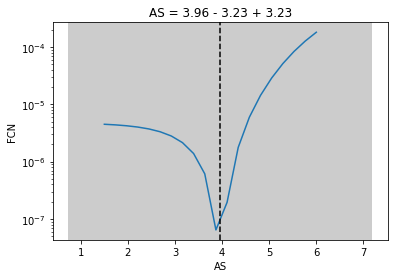

In [17]:
m.draw_profile('AS', bound=(1.5, 6), size=20)
plt.yscale('log')

Plotting contours for this set fails because `draw_contour` expects there will be contours 
for cost function values of 1,2,3, and 4, and as we see above, the cost function has values << 1.

In [18]:
#plot Om_ch2, AS contour plot
# x, y = 'Om_ch2', 'AS'

# m.draw_contour(x, y, size=10, bound=[[0.03,0.2],[3.,5.]])
# plt.yscale('log') 

<a id='datasets'></a>
## Create datasets ##

We now create dictionaries for datasets for all auto- and cross-correlation functions.\
To summarize all dictionaries created in next 3 cells:\
`data_dict` = Exact data calculated from Cosmology defined at top of notebook.\
`sigma_arr_dict` = Exact 10% of each data point in `data_dict`. Used as sigma to produce noise for following dictionaries.\
`seed_noisy_data_dict` = data where all datapoints for any function (e.g. Xi_14_+) have ~10% Gaussian errors **using the same seed for all functions.**\
`random_noisy_data_dict` = data where where all datapoints for any function have ~10% **random** Gaussian errors.

In [19]:
#create dictionary of N data points from each xi_plus and xi_minus function
N = 20
ell = np.arange(1, 2000)
theta_sample = np.logspace(-2, np.log10(2), N)

data_dict = {}

for i in range(4):
    for j in range(i,4,1):
        pair_str = str(i+1)+str(j+1)
        xip_str = 'xip_'+pair_str
        xim_str = 'xim_'+pair_str
        
        xi_p_ij = xi_pm_ij(theta_sample, 0.1, 4, i+1, j+1, '+')
        xi_m_ij = xi_pm_ij(theta_sample, 0.1, 4, i+1, j+1, '-')
        
        data_dict[xip_str] = xi_p_ij
        data_dict[xim_str] = xi_m_ij

data_dict

/home/yve/anaconda3/lib/python3.7/site-packages/pyccl/core.py:678: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  category=CCLWarning)


{'xip_11': array([5.07946448e-05, 4.59655201e-05, 4.06709049e-05, 3.59331291e-05,
        3.13944279e-05, 2.68559857e-05, 2.25463446e-05, 1.85042762e-05,
        1.48152645e-05, 1.15462967e-05, 8.83313048e-06, 6.68601507e-06,
        5.05857596e-06, 3.83520784e-06, 2.93717257e-06, 2.26309553e-06,
        1.74546012e-06, 1.33582559e-06, 1.00423827e-06, 7.34907837e-07]),
 'xim_11': array([4.64103115e-06, 5.26875321e-06, 4.67897363e-06, 4.60718361e-06,
        4.65801374e-06, 4.49402919e-06, 4.40592349e-06, 4.31599179e-06,
        4.23316478e-06, 4.09635971e-06, 3.90936089e-06, 3.61136239e-06,
        3.21655954e-06, 2.75089222e-06, 2.27508597e-06, 1.82374356e-06,
        1.43028320e-06, 1.10828456e-06, 8.56603323e-07, 6.66206025e-07]),
 'xip_12': array([1.04589811e-04, 9.36040949e-05, 8.15023689e-05, 7.10808600e-05,
        6.13378877e-05, 5.16997920e-05, 4.27565742e-05, 3.45601211e-05,
        2.72697373e-05, 2.09685599e-05, 1.59126796e-05, 1.20334794e-05,
        9.16607780e-06, 7.0153

In [20]:
#create noisy data with ~10% errors using fixed random seed for all correlation functions
import copy

seed_noisy_data_dict = {}
sigma_arr_dict = copy.deepcopy(data_dict) #dictionary of iterables: must use copy.deepcopy()

for key in data_dict:
    sigma_arr_dict[key] /= 10 #ten percent errors for each data point

    noise = st.norm.rvs(0, sigma_arr_dict[key], random_state=1369)
    xi_ij = data_dict[key]
    
    seed_noisy_data_dict[key] = xi_ij + noise
    
seed_noisy_data_dict

{'xip_11': array([4.87734893e-05, 4.41691196e-05, 4.05685490e-05, 3.38140112e-05,
        2.92931998e-05, 2.32739665e-05, 1.92787932e-05, 1.51481950e-05,
        1.33640633e-05, 1.10124027e-05, 7.78832274e-06, 6.60066567e-06,
        5.22310546e-06, 3.85288791e-06, 3.00647690e-06, 2.16431884e-06,
        1.88939594e-06, 1.41685996e-06, 1.03096861e-06, 7.64236140e-07]),
 'xim_11': array([4.45636117e-06, 5.06284254e-06, 4.66719812e-06, 4.33547988e-06,
        4.34625302e-06, 3.89462097e-06, 3.76739065e-06, 3.53320953e-06,
        3.81851313e-06, 3.90694642e-06, 3.44695060e-06, 3.56526205e-06,
        3.32117770e-06, 2.76357366e-06, 2.32876798e-06, 1.74414314e-06,
        1.54822859e-06, 1.17551575e-06, 8.79403984e-07, 6.92792614e-07]),
 'xip_12': array([1.00428107e-04, 8.99459084e-05, 8.12972532e-05, 6.68889423e-05,
        5.72325447e-05, 4.48041358e-05, 3.65600352e-05, 2.82920254e-05,
        2.45985817e-05, 1.99989859e-05, 1.40304827e-05, 1.18798677e-05,
        9.46420324e-06, 7.0476

In [21]:
#make correlation function dataset with random Gaussian ~10% errors
random_noisy_data_dict = {}
for key in data_dict:
    random_noisy_data_dict[key] = st.norm.rvs(data_dict[key], sigma_arr_dict[key])
    
random_noisy_data_dict

{'xip_11': array([5.44969984e-05, 4.70212677e-05, 4.87041649e-05, 3.60773401e-05,
        2.93903014e-05, 2.63653191e-05, 2.62690535e-05, 1.92920416e-05,
        1.59683531e-05, 1.12379219e-05, 8.47772754e-06, 5.70706182e-06,
        4.70848038e-06, 4.72874010e-06, 2.78372594e-06, 2.49518270e-06,
        1.41936163e-06, 1.45023221e-06, 8.88310746e-07, 6.03232700e-07]),
 'xim_11': array([5.14895946e-06, 6.09114813e-06, 4.64107933e-06, 4.70382307e-06,
        4.81905057e-06, 4.48565467e-06, 3.75205407e-06, 4.16145575e-06,
        3.67298819e-06, 3.82665623e-06, 3.52659701e-06, 4.05445708e-06,
        2.82514739e-06, 2.58142762e-06, 2.13176231e-06, 2.09423447e-06,
        1.43885329e-06, 1.10377380e-06, 8.37724113e-07, 6.13128791e-07]),
 'xip_12': array([9.05113618e-05, 1.04881240e-04, 1.04870700e-04, 8.00418701e-05,
        5.30283376e-05, 5.69473291e-05, 4.12939914e-05, 3.18905471e-05,
        2.49644423e-05, 2.31196739e-05, 1.57793479e-05, 1.43881538e-05,
        8.22967976e-06, 7.3983

## Joint fit all 1-4 bin combinations (24 correlation fctns) ##
Uses data with no errors. Expensive to run!\
I lost the output for this one; I leave running it as an exercise to the reader... :P

In [ ]:
lsqne_tot = None
for i in range(4):
    for j in range(i,4,1):
        pair_str = str(i+1)+str(j+1)
        xip_str = 'xip_'+pair_str
        xim_str = 'xim_'+pair_str
        lsqne_ij = (LeastSquaresNoErr(xi_pm_ij, theta_sample, data_dict[xip_str], i+1, j+1, '+')
                   +LeastSquaresNoErr(xi_pm_ij, theta_sample, data_dict[xim_str], i+1, j+1, '-'))
        
        if lsqne_tot is not None:
            lsqne_tot += lsqne_ij
        else:
            lsqne_tot = lsqne_ij

m2 = Minuit(lsqne_tot, Om_ch2=0.11, AS=4.1)

m2.limits['Om_ch2'] = (0.03, 0.7)
m2.limits['AS'] = (1.5, 6)

m2.migrad()

## Custom Least Squares cost function: ##

Non-linear least squares tailed to CCL shear-shear correlation function (`xi_ij_pm`).\
*NB:* this currently only fits exactly 2 parameters. For $k$ parameters, use `describe(model)[1:k+1]` in `__init__`.

In [35]:
class LeastSquares(Cost):
    """
    Generic least-squares cost function tailored for CCL shear-shear correlation function.
    """

    errordef = Minuit.LEAST_SQUARES # for Minuit to compute errors correctly
    
    def __init__(self, model, x, y, yerr):
        super().__init__(describe(model)[1:], len(x), verbose=1)
        self.model = model  # model predicts y for given x
        self.x = np.asarray(x)
        self.y = np.asarray(y)
        if len(y)==1:
            self.yerr = yerr * np.ones_like(y)
        else:
            self.yerr = yerr
    
    #overload __init__ for CCL model function
    def __init__(self, model, x, y, yerr, bin_i=None, bin_j=None, sign=None):
        super().__init__(describe(model)[1:3], len(x), verbose=1) #this will need to be changed 
                                                                  #if adding more fitting parameters
        self.model = model
        self.x = np.asarray(x)
        self.y = np.asarray(y)
        if len(y)==1:
            self.yerr = yerr * np.ones_like(y)
        else:
            self.yerr = np.asarray(yerr)       
        self.bin_i = bin_i
        self.bin_j = bin_j
        self.sign = sign
        
    def _call(self, *par):  # we accept a variable number of model parameters
        ym = self.model(self.x, bin_i = self.bin_i, bin_j = self.bin_j, sign=self.sign, *par[0])
        #ym = self.model(self.x, *par[0]) #uncomment to test linear data below
        return np.sum(((self.y - ym) / self.yerr) ** 2)

<ErrorbarContainer object of 3 artists>

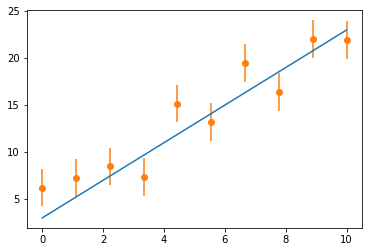

In [26]:
#test with linear data
def linear(x, a, b):
    return a*x + b

x = np.linspace(0,10,10)
a = 2
b = 3
y = st.norm.rvs(a*x+b, 2, random_state=720)

plt.plot(x, linear(x, a, b))
plt.errorbar(x, y, 2, fmt='o')

In [27]:
lsq_lin = LeastSquares(linear, x, y, 2)
mlin = Minuit(lsq_lin, a=1, b=1)

mlin.migrad()

(1.0, 1.0) -> 173.4812584716374
(1.0001, 1.0) -> 173.45811744811095
(0.9999, 1.0) -> 173.50440125442316
(1.000687692827589, 1.0) -> 173.32215486303542
(0.999312307172411, 1.0) -> 173.64044527937904
(1.0, 1.0001) -> 173.47738225154944
(1.0, 0.9999) -> 173.4851347417254
(1.0, 1.001) -> 173.44249852075745
(1.0, 0.999) -> 173.5200234225174
(2.3154344948705816, 8.752490107431907) -> 125.96753288221642
(1.7137813444031984, 5.20665782517712) -> 9.359781079111093
(1.7139489140655941, 5.20665782517712) -> 9.359669611422383
(1.7136137747408027, 5.20665782517712) -> 9.359897486727977
(1.7137813444031984, 5.207651799641996) -> 9.359898225753023
(1.7137813444031984, 5.205663850712244) -> 9.35966887239535
(1.7176577475425154, 5.183651451153047) -> 9.354906520883288
(1.7331633600997836, 5.091625955056751) -> 9.343717471556914
(1.7384603515214463, 5.060188418384402) -> 9.342941708623536
(1.738627784946517, 5.060188418384402) -> 9.342944174572999
(1.7382929180963755, 5.060188418384402) -> 9.34294417457

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 9.343 (chi2/ndof = 1.2)    │              Nfcn = 32               │
│ EDM = 9.51e-24 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.74    │   0.20    │            │            │         │         │       │
│ 1 │ b    │    5.1    │    1.2    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────┐
│   │      a      b │
├───┼───────────────┤
│ a │ 0.0393 -0.196 │
│ b │ -0.196   1.38 │
└───┴───────────────┘

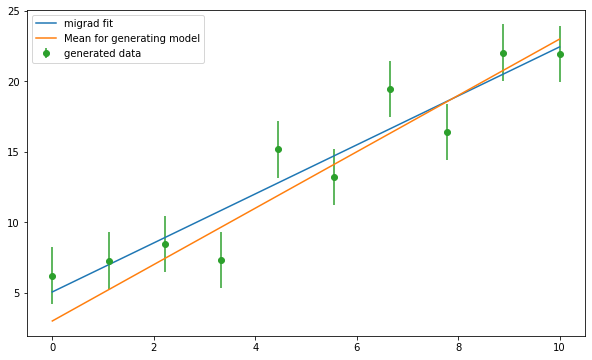

In [28]:
plt.figure(figsize=(10,6))
plt.plot(x, linear(x, mlin.values['a'], mlin.values['b']), label='migrad fit')
plt.plot(x, linear(x, a, b), label='Mean for generating model')
plt.errorbar(x, y, 2, fmt='o', label='generated data')
plt.legend()

(1.342113395100168, 5.060188418384402) -> 23.161123594849148
(1.3501204043208, 5.060188418384402) -> 22.608452714388005
(1.3581274135414318, 5.060188418384402) -> 22.067060831487296
(1.3661344227620638, 5.060188418384402) -> 21.536947946147027
(1.3741414319826957, 5.060188418384402) -> 21.018114058367182
(1.3821484412033274, 5.060188418384402) -> 20.510559168147765
(1.3901554504239593, 5.060188418384402) -> 20.014283275488772
(1.3981624596445912, 5.060188418384402) -> 19.52928638039022
(1.406169468865223, 5.060188418384402) -> 19.055568482852088
(1.414176478085855, 5.060188418384402) -> 18.593129582874383
(1.422183487306487, 5.060188418384402) -> 18.141969680457105
(1.4301904965271188, 5.060188418384402) -> 17.702088775600263
(1.4381975057477505, 5.060188418384402) -> 17.273486868303863
(1.4462045149683824, 5.060188418384402) -> 16.85616395856788
(1.4542115241890143, 5.060188418384402) -> 16.450120046392325
(1.4622185334096462, 5.060188418384402) -> 16.055355131777205
(1.47022554263027

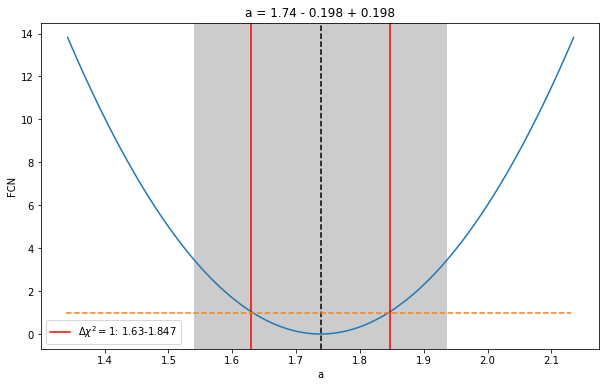

In [29]:
plt.figure(figsize=(10,6))
mlin.draw_profile('a', subtract_min=True)
plt.axvline(1.63, color='r', label=r'$\Delta\chi^2 = 1$: 1.63-1.847')
plt.axvline(1.847, color='r')

plt.plot(np.linspace(1.34,2.13,2), np.ones(2), linestyle='--')
plt.legend()

(1.7384603515214463, 2.7091731582041256) -> 23.161123592628947
(1.7384603515214463, 2.7566684159855455) -> 22.608452712256604
(1.7384603515214463, 2.8041636737669653) -> 22.067060829442873
(1.7384603515214463, 2.8516589315483847) -> 21.536947944187773
(1.7384603515214463, 2.8991541893298045) -> 21.01811405649128
(1.7384603515214463, 2.9466494471112243) -> 20.510559166353413
(1.7384603515214463, 2.994144704892644) -> 20.01428327377415
(1.7384603515214463, 3.041639962674064) -> 19.52928637875351
(1.7384603515214463, 3.0891352204554834) -> 19.0555684812915
(1.7384603515214463, 3.136630478236903) -> 18.59312958138809
(1.7384603515214463, 3.184125736018323) -> 18.141969679043314
(1.7384603515214463, 3.2316209937997424) -> 17.702088774257145
(1.7384603515214463, 3.2791162515811623) -> 17.273486867029597
(1.7384603515214463, 3.326611509362582) -> 16.856163957360664
(1.7384603515214463, 3.374106767144002) -> 16.450120045250348
(1.7384603515214463, 3.4216020249254218) -> 16.055355130698647
(1.7

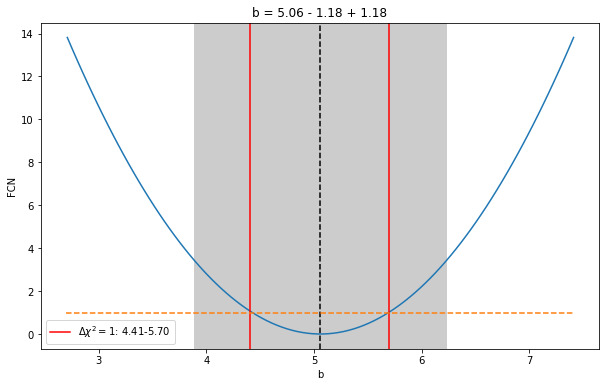

In [30]:
plt.figure(figsize=(10,6))
mlin.draw_profile('b', subtract_min=True)
plt.axvline(4.41, color='r', label=r'$\Delta\chi^2 = 1$: 4.41-5.70')
plt.axvline(5.70, color='r')
plt.plot(np.linspace(2.7,7.41,2), np.ones(2), linestyle='--')
plt.legend()

(1.342113395100168, 2.7091731582041256) -> 60.27474905066536
(1.342113395100168, 3.2316209937997424) -> 49.63894899411339
(1.342113395100168, 3.7540688293953597) -> 40.36790764215412
(1.342113395100168, 4.276516664990977) -> 32.46162499478759
(1.342113395100168, 4.798964500586594) -> 25.92010105201377
(1.342113395100168, 5.321412336182211) -> 20.743335813832694
(1.342113395100168, 5.843860171777828) -> 16.931329280244334
(1.342113395100168, 6.366308007373444) -> 14.484081451248699
(1.342113395100168, 6.888755842969061) -> 13.401592326845787
(1.342113395100168, 7.411203678564679) -> 13.683861907035594
(1.4301904965271188, 2.7091731582041256) -> 49.63894899323629
(1.4301904965271188, 3.2316209937997424) -> 40.153541211835474
(1.4301904965271188, 3.7540688293953597) -> 32.03289213502735
(1.4301904965271188, 4.276516664990977) -> 25.27700176281197
(1.4301904965271188, 4.798964500586594) -> 19.885870095189308
(1.4301904965271188, 5.321412336182211) -> 15.859497132159381
(1.4301904965271188,

(array([1.3421134 , 1.4301905 , 1.5182676 , 1.6063447 , 1.6944218 ,
        1.7824989 , 1.870576  , 1.95865311, 2.04673021, 2.13480731]),
 array([2.70917316, 3.23162099, 3.75406883, 4.27651666, 4.7989645 ,
        5.32141234, 5.84386017, 6.36630801, 6.88875584, 7.41120368]),
 array([[5.08782157e+01, 4.02424157e+01, 3.09713743e+01, 2.30650917e+01,
         1.65235677e+01, 1.13468025e+01, 7.53479596e+00, 5.08754814e+00,
         4.00505901e+00, 4.28732859e+00],
        [4.02424157e+01, 3.07570079e+01, 2.26363588e+01, 1.58804684e+01,
         1.04893368e+01, 6.46296382e+00, 3.80134956e+00, 2.50449400e+00,
         2.57239715e+00, 4.00505901e+00],
        [3.09713743e+01, 2.26363588e+01, 1.56661020e+01, 1.00606039e+01,
         5.81986453e+00, 2.94388384e+00, 1.43266186e+00, 1.28619858e+00,
         2.50449400e+00, 5.08754813e+00],
        [2.30650917e+01, 1.58804684e+01, 1.00606039e+01, 5.60549810e+00,
         2.51515098e+00, 7.89562567e-01, 4.28732859e-01, 1.43266186e+00,
         3.801

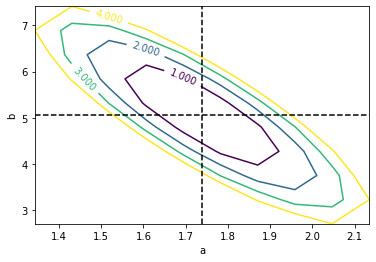

In [31]:
mlin.draw_contour('a', 'b', size=10)

Comparing with the LeastSquares function packaged with iminuit.\
Gets same results as above:

In [32]:
from iminuit.cost import LeastSquares as minuitLS

minuit_lsq_lin = minuitLS(x, y, 2, linear, verbose=1)
minuit_mlin = Minuit(minuit_lsq_lin, a=1, b=1)

minuit_mlin.migrad()

(1.0, 1.0) -> 173.48125847163743
(1.0001, 1.0) -> 173.45811744811095
(0.9999, 1.0) -> 173.5044012544231
(1.000687692849809, 1.0) -> 173.32215485789595
(0.9993123071501909, 1.0) -> 173.6404452845239
(1.0, 1.0001) -> 173.47738225154944
(1.0, 0.9999) -> 173.4851347417254
(1.0, 1.001) -> 173.44249852075745
(1.0, 0.999) -> 173.5200234225174
(2.3154344944972056, 8.752490195567516) -> 125.96753570826706
(1.7137813402468067, 5.206657849699689) -> 9.359781084766414
(1.7139489099092242, 5.206657849699689) -> 9.359669617057895
(1.7136137705843892, 5.206657849699689) -> 9.359897492403112
(1.7137813402468067, 5.207651824170487) -> 9.35989823142764
(1.7137813402468067, 5.2056638752288915) -> 9.359668878031421
(1.7176577440604162, 5.183651471696396) -> 9.354906524876863
(1.7331633593148537, 5.091625959683222) -> 9.343717471786032
(1.7384603515213157, 5.060188418384113) -> 9.342941708623531
(1.738627784946348, 5.060188418384113) -> 9.342944174572995
(1.7382929180962834, 5.060188418384113) -> 9.3429441

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 9.343 (chi2/ndof = 1.2)    │              Nfcn = 32               │
│ EDM = 6.02e-23 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.74    │   0.20    │            │            │         │         │       │
│ 1 │ b    │    5.1    │    1.2    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────┐
│   │      a      b │
├───┼───────────────┤
│ a │ 0.0393 -0.196 │
│ b │ -0.196   1.38 │
└───┴───────────────┘

(1.3421133979289679, 5.060188418384113) -> 23.161123397606293
(1.3501204070924497, 5.060188418384113) -> 22.608452525034302
(1.3581274162559314, 5.060188418384113) -> 22.067060649861734
(1.3661344254194132, 5.060188418384113) -> 21.53694777208858
(1.374141434582895, 5.060188418384113) -> 21.018113891714854
(1.3821484437463767, 5.060188418384113) -> 20.510559008740543
(1.3901554529098585, 5.060188418384113) -> 20.01428312316567
(1.3981624620733404, 5.060188418384113) -> 19.529286234990202
(1.406169471236822, 5.060188418384113) -> 19.055568344214176
(1.4141764804003039, 5.060188418384113) -> 18.59312945083755
(1.4221834895637857, 5.060188418384113) -> 18.14196955486035
(1.4301904987272673, 5.060188418384113) -> 17.702088656282587
(1.4381975078907492, 5.060188418384113) -> 17.273486755104233
(1.446204517054231, 5.060188418384113) -> 16.856163851325288
(1.4542115262177127, 5.060188418384113) -> 16.450119944945794
(1.4622185353811945, 5.060188418384113) -> 16.0553550359657
(1.47022554454467

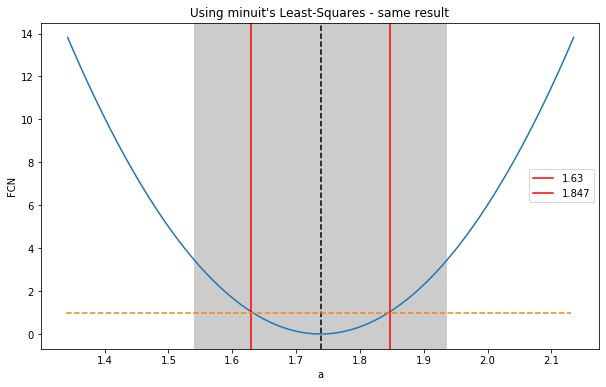

In [33]:
plt.figure(figsize=(10,6))
minuit_mlin.draw_profile('a', subtract_min=True)
plt.axvline(1.63, color='r', label='1.63')
plt.axvline(1.847, color='r', label='1.847')
plt.plot(np.linspace(1.34,2.13,2), np.ones(2), linestyle='--')
plt.title('Using minuit\'s Least-Squares - same result')
plt.legend()

(1.7384603515213157, 2.7091731739716027) -> 23.161123407288713
(1.7384603515213157, 2.756668431434482) -> 22.608452534329455
(1.7384603515213157, 2.804163688897361) -> 22.067060658777496
(1.7384603515213157, 2.8516589463602395) -> 21.536947780632897
(1.7384603515213157, 2.8991542038231186) -> 21.01811389989559
(1.7384603515213157, 2.9466494612859977) -> 20.51055901656563
(1.7384603515213157, 2.9941447187488768) -> 20.014283130642976
(1.7384603515213157, 3.041639976211756) -> 19.529286242127675
(1.7384603515213157, 3.0891352336746345) -> 19.05556835101968
(1.7384603515213157, 3.1366304911375136) -> 18.593129457319016
(1.7384603515213157, 3.1841257486003927) -> 18.141969561025675
(1.7384603515213157, 3.2316210060632717) -> 17.702088662139666
(1.7384603515213157, 3.2791162635261504) -> 17.273486760660983
(1.7384603515213157, 3.3266115209890295) -> 16.856163856589614
(1.7384603515213157, 3.3741067784519085) -> 16.45011994992558
(1.7384603515213157, 3.4216020359147876) -> 16.05535504066887


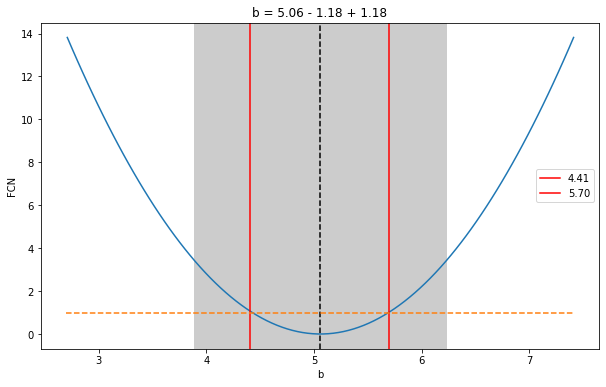

In [34]:
plt.figure(figsize=(10,6))
minuit_mlin.draw_profile('b', subtract_min=True)
plt.axvline(4.41, color='r', label='4.41')
plt.axvline(5.70, color='r', label='5.70')
plt.plot(np.linspace(2.7,7.41,2), np.ones(2), linestyle='--')
plt.legend()

Set up test for non-linear least squares with CCL model

/home/yve/anaconda3/lib/python3.7/site-packages/pyccl/core.py:678: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  category=CCLWarning)


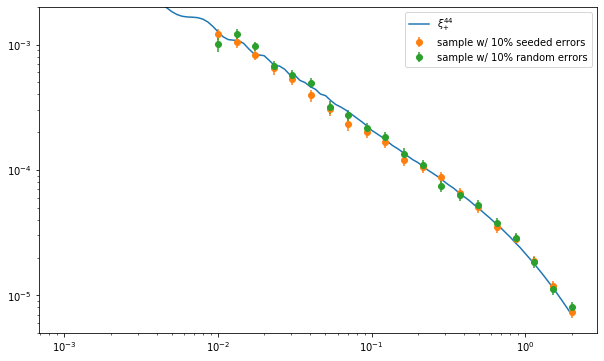

In [39]:
test_str = 'xip_44'
plt.figure(figsize=(10,6))
np.logspace(-2, np.log10(2), 20)
theta = np.logspace(-3, np.log10(2), 100)
xip_44 = xi_pm_ij(theta, 0.1, 4., 4, 4, '+')
plt.plot(theta, xip_44, label='$\\xi_{+}^{44}$')
plt.errorbar(theta_sample, seed_noisy_data_dict[test_str], sigma_arr_dict[test_str], 
             fmt='o', label='sample w/ 10% seeded errors')
plt.errorbar(theta_sample, random_noisy_data_dict[test_str], sigma_arr_dict[test_str], 
             fmt='o', label='sample w/ 10% random errors')

plt.ylim((5e-6,0.002))
plt.xscale('log')
plt.yscale('log')
plt.legend()

## Fitting with fixed seed data ##

First test with seeded data (orange data points).

In [40]:
#Testing custom LeastSquares with Xi_44_plus auto-correlation data with seeded Gaussian noise
lsq_p_44 = LeastSquares(xi_pm_ij, theta_sample, seed_noisy_data_dict[test_str], 
                        sigma_arr_dict[test_str], 4, 4, '+')

m3 = Minuit(lsq_p_44, Om_ch2=0.11, AS=4.1)

m3.limits['Om_ch2'] = (0.03, 0.7)
m3.limits['AS'] = (1.5, 6)

m3.migrad()

/home/yve/anaconda3/lib/python3.7/site-packages/pyccl/core.py:678: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  category=CCLWarning)


(0.11, 4.1) -> 366.28460869246607
(0.11001100056812463, 4.1) -> 366.77562829513755
(0.10998900008561167, 4.1) -> 365.79049392173056
(0.11000261667371834, 4.1) -> 366.40220229153766
(0.10999738336327225, 4.1) -> 366.1670386261117
(0.11, 4.100410019028989) -> 367.3673132422539
(0.11, 4.09958996905964) -> 365.20131432733336
(0.11, 4.100223426798175) -> 366.8743259431024
(0.11, 4.099776569664959) -> 365.69280255073886
(0.11, 4.099776569664959) -> 365.69280255073886
(0.11, 4.098882813001305) -> 363.34278764666425
(0.11, 4.096648174868014) -> 357.5118324436647
(0.11, 4.089942167706505) -> 340.388396378053
(0.11, 4.0698058401070165) -> 292.32633730365416
(0.11, 4.009246399082819) -> 175.60395963997942
(0.11, 3.8751806022840127) -> 38.62582357636532
(0.11000234470068629, 3.8751806022840127) -> 38.64818095652117
(0.10999765532901447, 3.8751806022840127) -> 38.60338713593901
(0.11000114625449815, 3.8751806022840127) -> 38.63680180436463
(0.10999885375260021, 3.8751806022840127) -> 38.61484883865

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 5.831 (chi2/ndof = 0.3)    │              Nfcn = 62               │
│ EDM = 4.52e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Om_ch2 │  0.0902   │  0.0015   │            │            │  0.03   │   0.7   │       │
│ 1 │ AS     │   4.15    │   0.04    │            │            │   1.5   │    6    │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────┐
│        │    Om_ch2        AS │
├────────┼─────────────────────┤
│ Om_ch2 │  2.36e-06 -4.82e-05 │
│     AS │ -4.82e-05   0.00138 │
└────────┴─────────────────────┘

(0.08250446739176358, 4.154097517872422) -> 64.56887964438586
(0.08265962796161556, 4.154097517872422) -> 62.334997050371015
(0.08281478853146754, 4.154097517872422) -> 60.139673309474176
(0.08296994910131952, 4.154097517872422) -> 57.98323013422299
(0.08312510967117151, 4.154097517872422) -> 55.8659423418246
(0.08328027024102348, 4.154097517872422) -> 53.78811582992461
(0.08343543081087547, 4.154097517872422) -> 51.75002385569971
(0.08359059138072746, 4.154097517872422) -> 49.75198500637857
(0.08374575195057943, 4.154097517872422) -> 47.794270974681545
(0.08390091252043141, 4.154097517872422) -> 45.87715593659315
(0.0840560730902834, 4.154097517872422) -> 44.00040789482114
(0.08421123366013537, 4.154097517872422) -> 42.16561028342514
(0.08436639422998736, 4.154097517872422) -> 40.372109976319244
(0.08452155479983935, 4.154097517872422) -> 38.6209162490504
(0.08467671536969132, 4.154097517872422) -> 36.91050006329112
(0.0848318759395433, 4.154097517872422) -> 35.24313177351224
(0.08498

(array([0.08250447, 0.08265963, 0.08281479, 0.08296995, 0.08312511,
        0.08328027, 0.08343543, 0.08359059, 0.08374575, 0.08390091,
        0.08405607, 0.08421123, 0.08436639, 0.08452155, 0.08467672,
        0.08483188, 0.08498704, 0.0851422 , 0.08529736, 0.08545252,
        0.08560768, 0.08576284, 0.085918  , 0.08607316, 0.08622832,
        0.08638348, 0.08653864, 0.0866938 , 0.08684896, 0.08700412,
        0.08715928, 0.08731445, 0.08746961, 0.08762477, 0.08777993,
        0.08793509, 0.08809025, 0.08824541, 0.08840057, 0.08855573,
        0.08871089, 0.08886605, 0.08902121, 0.08917637, 0.08933153,
        0.08948669, 0.08964185, 0.08979701, 0.08995217, 0.09010734,
        0.0902625 , 0.09041766, 0.09057282, 0.09072798, 0.09088314,
        0.0910383 , 0.09119346, 0.09134862, 0.09150378, 0.09165894,
        0.0918141 , 0.09196926, 0.09212442, 0.09227958, 0.09243474,
        0.0925899 , 0.09274507, 0.09290023, 0.09305539, 0.09321055,
        0.09336571, 0.09352087, 0.09367603, 0.09

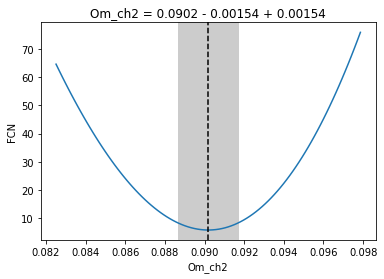

In [41]:
m3.draw_profile('Om_ch2', bound=5)
# plt.yscale('log')

(0.09018491559943669, 3.9684145054532913) -> 76.42453875804684
(0.09018491559943669, 3.9838880898215523) -> 66.20822285832067
(0.09018491559943669, 3.9993616741898133) -> 56.623790110383204
(0.09018491559943669, 4.014835258558074) -> 47.7137066921593
(0.09018491559943669, 4.030308842926335) -> 39.52217200896525
(0.09018491559943669, 4.045782427294596) -> 32.09531128460894
(0.09018491559943669, 4.061256011662857) -> 25.48125887386175
(0.09018491559943669, 4.076729596031118) -> 19.73023481802181
(0.09018491559943669, 4.092203180399379) -> 14.894517969852016
(0.09018491559943669, 4.10767676476764) -> 11.028694614129693
(0.09018491559943669, 4.1231503491359005) -> 8.189545146940015
(0.09018491559943669, 4.138623933504162) -> 6.43646652487995
(0.09018491559943669, 4.154097517872422) -> 5.8309859548782
(0.09018491559943669, 4.169571102240684) -> 6.437511436940068
(0.09018491559943669, 4.185044686608944) -> 8.32250884133267
(0.09018491559943669, 4.200518270977206) -> 11.555886555835784
(0.090

(array([3.96841451, 3.98388809, 3.99936167, 4.01483526, 4.03030884,
        4.04578243, 4.06125601, 4.0767296 , 4.09220318, 4.10767676,
        4.12315035, 4.13862393, 4.15409752, 4.1695711 , 4.18504469,
        4.20051827, 4.21599186, 4.23146544, 4.24693902, 4.26241261,
        4.27788619, 4.29335978, 4.30883336, 4.32430695, 4.33978053]),
 array([ 76.42453876,  66.20822286,  56.62379011,  47.71370669,
         39.52217201,  32.09531128,  25.48125887,  19.73023482,
         14.89451797,  11.02869461,   8.18954515,   6.43646652,
          5.83098595,   6.43751144,   8.32250884,  11.55588656,
         16.20990419,  22.35981873,  30.08389047,  39.4633667 ,
         50.58302457,  63.53063666,  78.39747092,  95.2773893 ,
        114.27055891]))

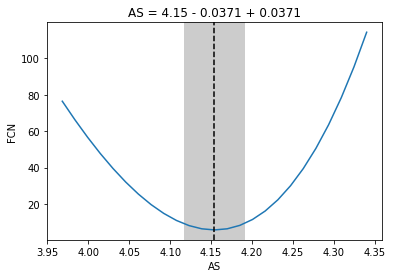

In [43]:
m3.draw_profile('AS', bound=5, size=25)
# plt.yscale('log')

/home/yve/anaconda3/lib/python3.7/site-packages/pyccl/core.py:678: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  category=CCLWarning)


(0.08, 4.05) -> 194.46834124325574
(0.08, 4.072222222222222) -> 174.09493703442945
(0.08, 4.094444444444444) -> 154.4155559894771
(0.08, 4.116666666666666) -> 135.5166360919777
(0.08, 4.138888888888888) -> 117.49140120829873
(0.08, 4.161111111111111) -> 100.43876980664555
(0.08, 4.183333333333334) -> 84.46612748302616
(0.08, 4.205555555555556) -> 69.68590107747005
(0.08, 4.227777777777778) -> 56.21899421803473
(0.08, 4.25) -> 44.19455821641814
(0.08222222222222222, 4.05) -> 147.74481222585482
(0.08222222222222222, 4.072222222222222) -> 129.04753628095708
(0.08222222222222222, 4.094444444444444) -> 111.2519131616214
(0.08222222222222222, 4.116666666666666) -> 94.45642684414979
(0.08222222222222222, 4.138888888888888) -> 78.76869755641052
(0.08222222222222222, 4.161111111111111) -> 64.3044716072706
(0.08222222222222222, 4.183333333333334) -> 51.186019019685304
(0.08222222222222222, 4.205555555555556) -> 39.5439693536238
(0.08222222222222222, 4.227777777777778) -> 29.517078412988294
(0.08

(array([0.08      , 0.08222222, 0.08444444, 0.08666667, 0.08888889,
        0.09111111, 0.09333333, 0.09555556, 0.09777778, 0.1       ]),
 array([4.05      , 4.07222222, 4.09444444, 4.11666667, 4.13888889,
        4.16111111, 4.18333333, 4.20555556, 4.22777778, 4.25      ]),
 array([[1.88571708e+02, 1.68198304e+02, 1.48518923e+02, 1.29620003e+02,
         1.11594768e+02, 9.45421367e+01, 7.85694944e+01, 6.37892680e+01,
         5.03223612e+01, 3.82979252e+01],
        [1.41848179e+02, 1.23150903e+02, 1.05355280e+02, 8.85597938e+01,
         7.28720645e+01, 5.84078385e+01, 4.52893860e+01, 3.36473363e+01,
         2.36204454e+01, 1.53566978e+01],
        [1.00592871e+02, 8.40081171e+01, 6.85540111e+01, 5.43484444e+01,
         4.15143833e+01, 3.01841484e+01, 2.04961255e+01, 1.26022600e+01,
         6.65856414e+00, 2.83421186e+00],
        [6.55095677e+01, 5.15031003e+01, 3.88867799e+01, 2.77932770e+01,
         1.83637589e+01, 1.07479520e+01, 5.10516772e+00, 1.60452918e+00,
         4.252

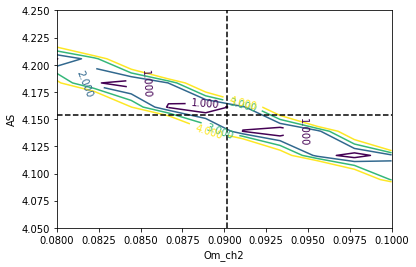

In [44]:
m3.draw_contour('Om_ch2', 'AS', size=10, bound=[[0.08,0.1],[4.05,4.25]])

We can also use the `minos` optimization algorithm to estimate parameters. This is more computationally expensive than `migrad` (see iminuit docs).

In [24]:
m3.minos()

(0.0917210052409713, 4.122688576370043) -> 5.921258390514057
(0.0917210052409713, 4.123059955980015) -> 5.920756104023252
(0.0917210052409713, 4.122317186319811) -> 5.922456839794648
(0.0917210052409713, 4.122725714801025) -> 5.921176817474976
(0.0917210052409713, 4.12265143783466) -> 5.921346925873958
(0.0917210052409713, 4.123143383190883) -> 5.920739124323466
(0.0917210052409713, 4.123168950972598) -> 5.920740964617895
(0.0917210052409713, 4.123117815359622) -> 5.920740589011289
(0.09325709488250593, 4.123143383190883) -> 8.629996938145856
(0.09325709488250593, 4.123342351250422) -> 8.662561805910729
(0.09325709488250593, 4.122944412130829) -> 8.597653601116129
(0.09325709488250593, 4.123172029408963) -> 8.634671746106667
(0.09325709488250593, 4.123114736910609) -> 8.62532672214531
(0.09325709488250593, 4.09081822278337) -> 6.182594471365105
(0.09325709488250593, 4.092950664246378) -> 6.175886330002813
(0.09325709488250593, 4.092975446607438) -> 6.175943184709674
(0.0932570948825059

(0.08674251016738696, 4.265507325323902) -> 10.49655685303557
(0.08495733063668533, 4.265507325323902) -> 6.950219590968892
(0.08509091497596472, 4.265507325323902) -> 6.936052114293884
(0.08509418412280215, 4.265507325323902) -> 6.936262440526834
(0.08508764591743187, 4.265507325323902) -> 6.935868122085539
(0.0850921542275076, 4.265507325323902) -> 6.936129272299927
(0.08508967573711121, 4.265507325323902) -> 6.935979654447369
(0.08506784410048392, 4.265507325323902) -> 6.93532199383337
(0.08506667104922372, 4.265507325323902) -> 6.935320432725221
(0.08506778297454662, 4.265507325323902) -> 6.935321583216663
(0.08506555913412164, 4.265507325323902) -> 6.935321523127741
(0.08506667104922372, 4.260167735104601) -> 6.900944596231902
(0.08507563456392699, 4.260167735104601) -> 6.895778077901724
(0.08505770819866446, 4.260167735104601) -> 6.906306383076591
(0.08506791605946279, 4.260167735104601) -> 6.900214664257668
(0.08506542605179848, 4.260167735104601) -> 6.9016771725151225
(0.085302

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 5.831 (chi2/ndof = 0.3)    │              Nfcn = 264              │
│ EDM = 4.52e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Om_ch2 │  0.0902   │  0.0015   │  -0.0050   │   0.0053   │  0.03   │   0.7   │       │
│ 1 │ AS     │   4.15    │   0.04    │   -0.11    │    0.11    │   1.5   │    6    │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │        Om_ch2         │          AS           │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.005   │   0.005   │   -0.11   │   0.11    │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌────────┬─────────────────────┐
│        │    Om_ch2        AS │
├────────┼─────────────────────┤
│ Om_ch2 │  2.36e-06 -4.82e-05 │
│     AS │ -4.82e-05   0.00138 │
└────────┴─────────────────────┘

In [36]:
om_results = m3.mnprofile('Om_ch2', size=10, bound=(0.08, 0.1))

(0.08, 4.154097517872422) -> 105.70912924370168
(0.08, 4.154468897375693) -> 105.42741265187844
(0.08, 4.153726126992624) -> 105.99114605964645
(0.08, 4.154250409916917) -> 105.593114818235
(0.08, 4.1539446238998) -> 105.82519446888266
(0.08, 4.303032567336382) -> 22.153113098624175
(0.08, 4.43203939109098) -> 19.658353540733263
(0.08, 4.37264821881725) -> 10.413083729881205
(0.08, 4.372697102200195) -> 10.412799475490496
(0.08, 4.372599335116029) -> 10.413380131419586
(0.08, 4.37268093865275) -> 10.412892124257361
(0.08, 4.372615498839155) -> 10.413279366757227
(0.08, 4.374304309900372) -> 10.410217765968435
(0.08, 4.373818496251854) -> 10.40961176541871
(0.08, 4.373856501509712) -> 10.409615803499209
(0.08, 4.37378049080119) -> 10.409615084304846
(0.08, 4.373818496251854) -> 10.40961176541871
(0.08, 4.373856501509712) -> 10.409615803499209
(0.08, 4.37378049080119) -> 10.409615084304846
(0.08, 4.373826097318851) -> 10.409611984444355
(0.08, 4.3738108951771455) -> 10.409611840663551
(0

(0.09777777777777778, 4.154097517872422) -> 74.18870454795773
(0.09777777777777778, 4.154468897375693) -> 74.54905187715455
(0.09777777777777778, 4.153726126992624) -> 73.82947347533535
(0.09777777777777778, 4.154164076249598) -> 74.25320285883784
(0.09777777777777778, 4.154030959129847) -> 74.12424206441852
(0.09777777777777778, 3.961387142684791) -> 12.339262356323086
(0.09777777777777778, 4.009735380027512) -> 7.847230686677954
(0.09777777777777778, 4.009758441745225) -> 7.847764614577551
(0.09777777777777778, 4.009712318282144) -> 7.846681890603635
(0.09777777777777778, 4.009747664362942) -> 7.847524130419427
(0.09777777777777778, 4.009723095684235) -> 7.846938020498624
(0.09777777777777778, 4.00603747513539) -> 7.793772880218577
(0.09777777777777778, 4.005042037556599) -> 7.791194988665667
(0.09777777777777778, 4.005070567305062) -> 7.7911995063693755
(0.09777777777777778, 4.005013507766597) -> 7.791194559743895
(0.09777777777777778, 4.005042037556599) -> 7.791194988665667
(0.0977

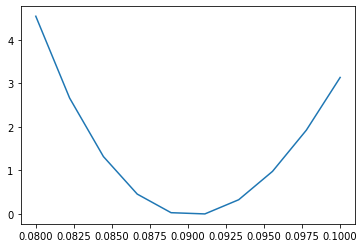

In [37]:
omch2_arr = om_results[0]
fval_arr = om_results[1]
delta_fval_arr = fval_arr - np.min(fval_arr)

plt.plot(omch2_arr, delta_fval_arr)

In [30]:
m3.mnprofile('AS', size=10, bound=(4.0, 4.2))

/home/yve/anaconda3/lib/python3.7/site-packages/pyccl/core.py:678: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  category=CCLWarning)


(0.09018491559943669, 4.0) -> 56.2425932967145
(0.09020027856038695, 4.0) -> 56.05517750004051
(0.09016955440556, 4.0) -> 56.43030687588605
(0.0901895666667365, 4.0) -> 56.18582211179066
(0.09018026469411068, 4.0) -> 56.29939538263511
(0.09437604011292787, 4.0) -> 18.007833220411655
(0.0990077744710579, 4.0) -> 9.26904250687018
(0.09789218318256936, 4.0) -> 7.867869861873873
(0.09789399894992765, 4.0) -> 7.868279587056326
(0.09789036743675408, 4.0) -> 7.867465991090895
(0.09774191385533494, 4.0) -> 7.854896591070837
(0.09776996938759583, 4.0) -> 7.85418292482241
(0.09777151013257733, 4.0) -> 7.854186506471525
(0.09776842865815763, 4.0) -> 7.854184341260593
(0.09776996938759583, 4.0) -> 7.85418292482241
(0.09777151013257733, 4.0) -> 7.854186506471525
(0.09776842865815763, 4.0) -> 7.854184341260593
(0.09777027753534868, 4.0) -> 7.854183156326032
(0.09776966124046473, 4.0) -> 7.854179214569343
(0.09777003101709666, 4.0) -> 7.854183623402769
(0.09776990775811985, 4.0) -> 7.854183138464948


(0.09018645181601503, 4.133333333333334) -> 6.906722972190993
(0.09018337940052909, 4.133333333333334) -> 6.913125576736988
(0.0908912697417956, 4.133333333333334) -> 5.957252116678597
(0.09119198385561816, 4.133333333333334) -> 5.8726263190110535
(0.09119294833795413, 4.133333333333334) -> 5.872656245469361
(0.09119101938011909, 4.133333333333334) -> 5.87259937502451
(0.09117777891186107, 4.133333333333334) -> 5.872438420415294
(0.09117910207377386, 4.133333333333334) -> 5.872438202884158
(0.09118011296755904, 4.133333333333334) -> 5.8724396842671425
(0.09117809118750118, 4.133333333333334) -> 5.872438966461412
(0.09117910207377386, 4.133333333333334) -> 5.872438202884158
(0.09118011296755904, 4.133333333333334) -> 5.8724396842671425
(0.09117809118750118, 4.133333333333334) -> 5.872438966461412
(0.0911793042519299, 4.133333333333334) -> 5.8724388796871105
(0.09117889989591835, 4.133333333333334) -> 5.872438578204799
(0.09117914250938104, 4.133333333333334) -> 5.872438111824479
(0.0911

/home/yve/anaconda3/lib/python3.7/site-packages/iminuit/minuit.py:1058: IMinuitWarning: MIGRAD fails to converge for AS=4.155555555555556
  warn(f"MIGRAD fails to converge for {vname}={v}", mutil.IMinuitWarning)


(0.09018491559943669, 4.177777777777778) -> 7.273726365943588
(0.09020027856038695, 4.177777777777778) -> 7.312967679157908
(0.09016955440556, 4.177777777777778) -> 7.235042726094029
(0.09018645181601503, 4.177777777777778) -> 7.2776249693861885
(0.09018337940052909, 4.177777777777778) -> 7.26983409305183
(0.08933041655549963, 4.177777777777778) -> 5.9504460375437365
(0.08909389383988496, 4.177777777777778) -> 5.878805246364096
(0.08909499054078307, 4.177777777777778) -> 5.87884652240087
(0.08909279714817897, 4.177777777777778) -> 5.878766344270852
(0.08907813540875475, 4.177777777777778) -> 5.8785103538315955
(0.08907942435040456, 4.177777777777778) -> 5.878512773680902
(0.08907684647980592, 4.177777777777778) -> 5.878511403530667
(0.08907813540875475, 4.177777777777778) -> 5.8785103538315955
(0.08907942435040456, 4.177777777777778) -> 5.878512773680902
(0.08907684647980592, 4.177777777777778) -> 5.878511403530667
(0.08907839319606863, 4.177777777777778) -> 5.878510468209281
(0.089077

(array([4.        , 4.02222222, 4.04444444, 4.06666667, 4.08888889,
        4.11111111, 4.13333333, 4.15555556, 4.17777778, 4.2       ]),
 array([7.85418292, 7.32111812, 6.86757683, 6.4945691 , 6.20338035,
        5.99511007, 5.8724382 , 5.83099018, 5.87851035, 6.01368415]),
 array([ True,  True,  True,  True,  True,  True,  True, False,  True,
         True]))

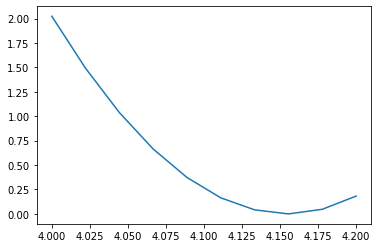

In [32]:
as_arr = np.array([4., 4.02222222, 4.04444444, 4.06666667, 4.08888889,
        4.11111111, 4.13333333, 4.15555556, 4.17777778, 4.2])
fval_2_arr = np.array([7.85418292, 7.32111812, 6.86757683, 6.4945691 , 6.20338035,
        5.99511007, 5.8724382 , 5.83099018, 5.87851035, 6.01368415])
fval_2_min_arr = fval_2_arr - np.min(fval_2_arr)

plt.plot(as_arr, fval_2_min_arr)

In [38]:
m3.mncontour('Om_ch2', 'AS', size=10)

/home/yve/anaconda3/lib/python3.7/site-packages/pyccl/core.py:678: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  category=CCLWarning)


(0.0917210052409713, 4.106653635529525) -> 6.594978702823412
(0.0917210052409713, 4.1070250152048855) -> 6.5652272126975335
(0.0917210052409713, 4.10628224588678) -> 6.625389037993729
(0.0917210052409713, 4.106690773945765) -> 6.591973892468867
(0.0917210052409713, 4.106616497013611) -> 6.597990101805462
(0.0917210052409713, 4.12276770662528) -> 5.921092971571303
(0.0917210052409713, 4.122796282477516) -> 5.921041004311725
(0.0917210052409713, 4.122739130711219) -> 5.921149061917909
(0.0917210052409713, 4.123152141319133) -> 5.9207393825400025
(0.0917210052409713, 4.123179967710849) -> 5.920742776456549
(0.0917210052409713, 4.123124314868732) -> 5.920739903412716
(0.09325709488250593, 4.123152141319133) -> 8.631425698328616
(0.09325709488250593, 4.123452479409799) -> 8.68068185790312
(0.09325709488250593, 4.122851796391491) -> 8.58267432092694
(0.09325709488250593, 4.09082188550008) -> 6.1825633362348915
(0.09325709488250593, 4.092951087509096) -> 6.175887274963152
(0.09325709488250593

(0.08283255186921779, 4.317889888071182) -> 8.25654354875507
(0.08283255186921779, 4.317292022548449) -> 8.234105653167733
(0.08283255186921779, 4.317621978976861) -> 8.246258183507443
(0.08283255186921779, 4.317559942227302) -> 8.243929959026705
(0.08283255186921779, 4.310229593921038) -> 8.109073626752703
(0.08283255186921779, 4.310260438104416) -> 8.109063539661836
(0.08283255186921779, 4.310198749625423) -> 8.109088553409844
(0.0882406276618076, 4.191234120356249) -> 6.000200063945733
(0.08825599073819997, 4.191234120356249) -> 5.993120578405003
(0.08822526641857459, 4.191234120356249) -> 6.007814245697433
(0.08824216388695635, 4.191234120356249) -> 5.999467971670056
(0.08823909145499047, 4.191234120356249) -> 6.000936962534725
(0.08839763682122795, 4.191234120356249) -> 5.953065607474302
(0.0884518549401627, 4.191234120356249) -> 5.949810134142965
(0.08845324524428386, 4.191234120356249) -> 5.949807536776299
(0.08845046465099549, 4.191234120356249) -> 5.949810435687995
(0.08845185

(0.0974861736721468, 4.005551107937116) -> 7.7136463358335385
(0.09748374425888134, 4.005551107937116) -> 7.713653301100837
(0.09748495896066021, 3.987457142022408) -> 8.957916366730622
(0.09750073398789576, 3.987457142022408) -> 8.932146307273296
(0.09746918557049936, 3.987457142022408) -> 8.984119529131705
(0.09748671348986426, 3.987457142022408) -> 8.955029384224607
(0.09748320445170919, 3.987457142022408) -> 8.960808797728465
(0.0983866877199334, 3.987457142022408) -> 8.189106655156033
(0.09838837697710509, 3.987457142022408) -> 8.189026273424995
(0.09838499848125351, 3.987457142022408) -> 8.189191093534845
(0.09841446410754698, 3.987457142022408) -> 8.188441982853433
(0.0984163382091591, 3.987457142022408) -> 8.188447389293813
(0.0984125900286844, 3.987457142022408) -> 8.188442921904013
(0.09841446410754698, 3.990321303909114) -> 8.129422427216966
(0.09843038366003735, 3.990321303909114) -> 8.133915856528665
(0.09839854619643304, 3.990321303909114) -> 8.12538983452079
(0.098416116

array([[0.08283136, 4.31018723],
       [0.08543363, 4.23016267],
       [0.08891746, 4.15017163],
       [0.09293852, 4.07020434],
       [0.098267  , 3.99031351],
       [0.09841201, 3.9930902 ],
       [0.0953999 , 4.07315942],
       [0.09166628, 4.15319825],
       [0.08771533, 4.23322685],
       [0.08295866, 4.3132116 ]])

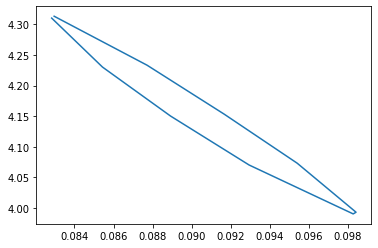

In [43]:
m3_contour = np.array([[0.08283136, 4.31018723],
       [0.08543363, 4.23016267],
       [0.08891746, 4.15017163],
       [0.09293852, 4.07020434],
       [0.098267  , 3.99031351],
       [0.09841201, 3.9930902 ],
       [0.0953999 , 4.07315942],
       [0.09166628, 4.15319825],
       [0.08771533, 4.23322685],
       [0.08295866, 4.3132116 ]])

plt.plot(contour[:,0], contour[:,1])

# Fitting with perfect data w/ ~10% errors #

Testing migrad and minos with perfect data (`data_dict`) w/ ~10% errors.

In [44]:
lsq_p_44_v3 = LeastSquares(xi_pm_ij, theta_sample, data_dict['xip_44'], 
                           sigma_arr_dict['xip_44'], 4, 4, '+')

m4 = Minuit(lsq_p_44_v3, Om_ch2=0.11, AS=4.1)

m4.limits['Om_ch2'] = (0.03, 0.7)
m4.limits['AS'] = (1.5, 6)

m4.migrad()

/home/yve/anaconda3/lib/python3.7/site-packages/pyccl/core.py:678: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  category=CCLWarning)


(0.11, 4.1) -> 282.8654517532808
(0.11001100056812463, 4.1) -> 283.2993563766312
(0.10998900008561167, 4.1) -> 282.42924647402293
(0.11000266821499857, 4.1) -> 282.9713143468397
(0.10999733182346356, 4.1) -> 282.7596081600525
(0.11, 4.100410019028989) -> 283.8340330708617
(0.11, 4.09958996905964) -> 281.89690236934695
(0.11, 4.100844139803032) -> 284.86184739329633
(0.11, 4.099155809708076) -> 280.87582079668135
(0.09574340955760546, 3.849621547847077) -> 111.66304831871858
(0.10150899145450794, 3.9538308659517565) -> 0.9817307484235634
(0.10150955806339365, 3.9538308659517565) -> 0.9807789508239676
(0.10150842484759878, 3.9538308659517565) -> 0.9826833829137783
(0.10150899145450794, 3.953915971177695) -> 0.9734597021406776
(0.10150899145450794, 3.953745760431784) -> 0.9900386145824686
(0.10150899145450794, 3.9538444999447067) -> 0.9804032414692001
(0.10150899145450794, 3.953817231951261) -> 0.9830592444412014
(0.10182669057972685, 3.959754983289836) -> 0.22556174267964044
(0.102007121

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 8.112e-07 (chi2/ndof = 0.0)│              Nfcn = 52               │
│ EDM = 8.22e-07 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Om_ch2 │   0.100   │   0.006   │            │            │  0.03   │   0.7   │       │
│ 1 │ AS     │   4.00    │   0.11    │            │            │   1.5   │    6    │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────┐
│        │    Om_ch2        AS │
├────────┼─────────────────────┤
│ Om_ch2 │  3.43e-05 -0.000632 │
│     AS │ -0.000632     0.012 │
└────────┴─────────────────────┘

(0.08828637489848867, 3.9999178843663343) -> 114.88309184698764
(0.08852311104434413, 3.9999178843663343) -> 110.5895341990414
(0.08875984719019958, 3.9999178843663343) -> 106.36497764105481
(0.08899658333605504, 3.9999178843663343) -> 102.2102186021494
(0.08923331948191049, 3.9999178843663343) -> 98.12622629762384
(0.08947005562776594, 3.9999178843663343) -> 94.11359330389816
(0.0897067917736214, 3.9999178843663343) -> 90.1729095235276
(0.08994352791947685, 3.9999178843663343) -> 86.30514003632474
(0.0901802640653323, 3.9999178843663343) -> 82.51109291416132
(0.09041700021118776, 3.9999178843663343) -> 78.79146248899815
(0.09065373635704321, 3.9999178843663343) -> 75.14710617314825
(0.09089047250289867, 3.9999178843663343) -> 71.57881281118014
(0.09112720864875412, 3.9999178843663343) -> 68.10291600188532
(0.09136394479460959, 3.9999178843663343) -> 64.69453775096673
(0.09160068094046504, 3.9999178843663343) -> 61.35244277276185
(0.0918374170863205, 3.9999178843663343) -> 58.102854542

(array([0.08828637, 0.08852311, 0.08875985, 0.08899658, 0.08923332,
        0.08947006, 0.08970679, 0.08994353, 0.09018026, 0.090417  ,
        0.09065374, 0.09089047, 0.09112721, 0.09136394, 0.09160068,
        0.09183742, 0.09207415, 0.09231089, 0.09254763, 0.09278436,
        0.0930211 , 0.09325783, 0.09349457, 0.09373131, 0.09396804,
        0.09420478, 0.09444151, 0.09467825, 0.09491499, 0.09515172,
        0.09538846, 0.0956252 , 0.09586193, 0.09609867, 0.0963354 ,
        0.09657214, 0.09680888, 0.09704561, 0.09728235, 0.09751908,
        0.09775582, 0.09799256, 0.09822929, 0.09846603, 0.09870277,
        0.0989395 , 0.09917624, 0.09941297, 0.09964971, 0.09988645,
        0.10012318, 0.10035992, 0.10059665, 0.10083339, 0.10107013,
        0.10130686, 0.1015436 , 0.10178034, 0.10201707, 0.10225381,
        0.10249054, 0.10272728, 0.10296402, 0.10320075, 0.10343749,
        0.10367422, 0.10391096, 0.1041477 , 0.10438443, 0.10462117,
        0.10485791, 0.10509464, 0.10533138, 0.10

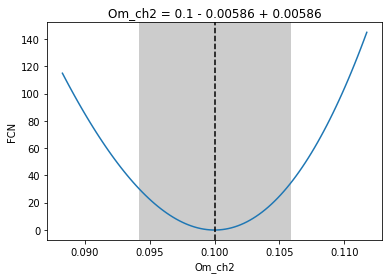

In [47]:
m4.draw_profile('Om_ch2', bound=2)

/home/yve/anaconda3/lib/python3.7/site-packages/pyccl/core.py:678: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  category=CCLWarning)


(0.10000481411833367, 3.7808043600663566) -> 101.46038534580904
(0.10000481411833367, 3.7852308959108005) -> 97.8856345598347
(0.10000481411833367, 3.7896574317552445) -> 94.35686139255053
(0.10000481411833367, 3.7940839675996885) -> 90.87497317986491
(0.10000481411833367, 3.7985105034441324) -> 87.44092163877703
(0.10000481411833367, 3.8029370392885764) -> 84.05564215792523
(0.10000481411833367, 3.8073635751330204) -> 80.72009706417802
(0.10000481411833367, 3.8117901109774643) -> 77.43523984645189
(0.10000481411833367, 3.8162166468219088) -> 74.20206336262454
(0.10000481411833367, 3.8206431826663527) -> 71.02156495412626
(0.10000481411833367, 3.8250697185107967) -> 67.89473059027004
(0.10000481411833367, 3.8294962543552407) -> 64.82258828788177
(0.10000481411833367, 3.8339227901996846) -> 61.80639578052552
(0.10000481411833367, 3.8383493260441286) -> 58.84686313375107
(0.10000481411833367, 3.8427758618885726) -> 55.94487593622212
(0.10000481411833367, 3.8472023977330165) -> 53.1018976

(array([3.78080436, 3.7852309 , 3.78965743, 3.79408397, 3.7985105 ,
        3.80293704, 3.80736358, 3.81179011, 3.81621665, 3.82064318,
        3.82506972, 3.82949625, 3.83392279, 3.83834933, 3.84277586,
        3.8472024 , 3.85162893, 3.85605547, 3.86048201, 3.86490854,
        3.86933508, 3.87376161, 3.87818815, 3.88261468, 3.88704122,
        3.89146776, 3.89589429, 3.90032083, 3.90474736, 3.9091739 ,
        3.91360044, 3.91802697, 3.92245351, 3.92688004, 3.93130658,
        3.93573311, 3.94015965, 3.94458619, 3.94901272, 3.95343926,
        3.95786579, 3.96229233, 3.96671887, 3.9711454 , 3.97557194,
        3.97999847, 3.98442501, 3.98885154, 3.99327808, 3.99770462,
        4.00213115, 4.00655769, 4.01098422, 4.01541076, 4.0198373 ,
        4.02426383, 4.02869037, 4.0331169 , 4.03754344, 4.04196997,
        4.04639651, 4.05082305, 4.05524958, 4.05967612, 4.06410265,
        4.06852919, 4.07295573, 4.07738226, 4.0818088 , 4.08623533,
        4.09066187, 4.09508841, 4.09951494, 4.10

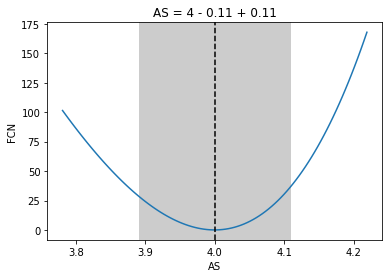

In [48]:
m4.draw_profile('AS', bound=2)

/home/yve/anaconda3/lib/python3.7/site-packages/pyccl/core.py:678: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  category=CCLWarning)


(0.08828637489848867, 3.7808043600663566) -> 335.76500121515267
(0.08828637489848867, 3.8294962543552407) -> 282.06114390065306
(0.08828637489848867, 3.8781881486441248) -> 230.321804166115
(0.08828637489848867, 3.9268800429330084) -> 181.30807034389522
(0.08828637489848867, 3.9755719372218925) -> 135.91024404367747
(0.08828637489848867, 4.024263831510776) -> 95.15775470838948
(0.08828637489848867, 4.072955725799661) -> 60.237581503786096
(0.08828637489848867, 4.121647620088544) -> 32.512459180066024
(0.08828637489848867, 4.170339514377429) -> 13.543878275301715
(0.08828637489848867, 4.2190314086663125) -> 5.113870789017248
(0.09089047250289867, 3.7808043600663566) -> 275.05200842437426
(0.09089047250289867, 3.8294962543552407) -> 223.52073406405708
(0.09089047250289867, 3.8781881486441248) -> 174.80287573300018
(0.09089047250289867, 3.9268800429330084) -> 129.79912512514795
(0.09089047250289867, 3.9755719372218925) -> 89.55118389691525
(0.09089047250289867, 4.024263831510776) -> 55.25

(array([0.08828637, 0.09089047, 0.09349457, 0.09609867, 0.09870277,
        0.10130686, 0.10391096, 0.10651506, 0.10911916, 0.11172325]),
 array([3.78080436, 3.82949625, 3.87818815, 3.92688004, 3.97557194,
        4.02426383, 4.07295573, 4.12164762, 4.17033951, 4.21903141]),
 array([[3.35713938e+02, 2.82010081e+02, 2.30270741e+02, 1.81257007e+02,
         1.35859181e+02, 9.51066914e+01, 6.01865182e+01, 3.24613959e+01,
         1.34928150e+01, 5.06280747e+00],
        [2.75000945e+02, 2.23469671e+02, 1.74751812e+02, 1.29748062e+02,
         8.95001206e+01, 5.52078167e+01, 2.82478403e+01, 1.01964611e+01,
         2.84940428e+00, 8.25054398e+00],
        [2.18683337e+02, 1.70191066e+02, 1.25482182e+02, 8.56053480e+01,
         5.17673755e+01, 2.53531990e+01, 7.94642330e+00, 1.35063842e+00,
         7.61578086e+00, 2.90633370e+01],
        [1.67381329e+02, 1.22868413e+02, 8.32316552e+01, 4.96815932e+01,
         2.36052601e+01, 6.58697551e+00, 4.31012109e-01, 7.18617820e+00,
         2.917

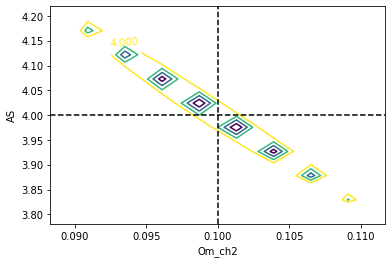

In [49]:
m4.draw_contour('Om_ch2', 'AS', size=10)

In [50]:
m4.minos()

(0.10586403372825617, 3.8917645468828477) -> 0.9812532955557385
(0.10586403372825617, 3.8928605378957566) -> 0.9656424183496629
(0.10586403372825617, 3.890668522097884) -> 1.0032572800492536
(0.10586403372825617, 3.8918741475081893) -> 0.9794038504639717
(0.10586403372825617, 3.8916549459197856) -> 0.9831667336558652
(0.10586403372825617, 3.8949581309400223) -> 0.9536953201221614
(0.10586403372825617, 3.8949713536777093) -> 0.9536949844666753
(0.10586403372825617, 3.8949449081973073) -> 0.953696597397748
(0.10600459148157547, 3.8949581309400223) -> 1.0141676268958202
(0.10600459148157547, 3.8951513534472717) -> 1.0168150999009193
(0.10600459148157547, 3.894764907359273) -> 1.011722779143164
(0.10600459148157547, 3.894977453239078) -> 1.0144232496926529
(0.10600459148157547, 3.894938808630231) -> 1.0139139362385072
(0.10600459148157547, 3.892497767769216) -> 0.9981359060022179
(0.10600459148157547, 3.8925113373869378) -> 0.9981346793822359
(0.10600459148157547, 3.892484198146291) -> 0.9

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 8.112e-07 (chi2/ndof = 0.0)│              Nfcn = 414              │
│ EDM = 8.22e-07 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Om_ch2 │   0.100   │   0.006   │   -0.006   │   0.006    │  0.03   │   0.7   │       │
│ 1 │ AS     │   4.00    │   0.11    │   -0.11    │    0.11    │   1.5   │    6    │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │        Om_ch2         │          AS           │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.006   │   0.006   │   -0.11   │   0.11    │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌────────┬─────────────────────┐
│        │    Om_ch2        AS │
├────────┼─────────────────────┤
│ Om_ch2 │  3.43e-05 -0.000632 │
│     AS │ -0.000632     0.012 │
└────────┴─────────────────────┘

## Fitting to $\xi_+^{44}$  and  $\xi_-^{44}$  ##

In [67]:
#test adding two cost functions
xip_str = 'xip_44'
xim_str = 'xim_44'
lsq_pm44 = (LeastSquares(xi_pm_ij, theta_sample, random_noisy_data_dict[xip_str], 
                       sigma_arr_dict[xip_str], 4, 4, '+')
          +LeastSquares(xi_pm_ij, theta_sample, random_noisy_data_dict[xim_str],
                        sigma_arr_dict[xim_str], 4, 4, '-'))
print(lsq_pm44)

In [68]:
m_44test = Minuit(lsq_pm44, Om_ch2=0.105, AS=4.05)

m_44test.limits['Om_ch2'] = (0.03, 0.7)
m_44test.limits['AS'] = (1.5, 6)

m_44test.migrad(ncall=25)

/home/yve/anaconda3/lib/python3.7/site-packages/pyccl/core.py:678: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  category=CCLWarning)


(0.10499999999999998, 4.05) -> 183.15173417206773
(0.10501050056092714, 4.05) -> 183.57070506955438
(0.10498950008145509, 4.05) -> 182.7330152645402
(0.10500619852548052, 4.05) -> 183.39922564337678
(0.104993801698369, 4.05) -> 182.90447955301437
(0.10499999999999998, 4.050405018527995) -> 184.00454335671873
(0.10499999999999998, 4.0495949715749315) -> 182.3013402471441
(0.10499999999999998, 4.050077227187673) -> 183.3142045486088
(0.10499999999999998, 4.049922772452504) -> 182.98936712505733
(0.09864935034695076, 3.928225565880084) -> 88.16029962346715
(0.10107489252306126, 3.975380521020847) -> 38.41197267254037
(0.10107659781392307, 3.975380521020847) -> 38.410823627327936
(0.10107318725022901, 3.975380521020847) -> 38.4131255077306
(0.10107868988574666, 3.975380521020847) -> 38.40943174418079
(0.10107109524977764, 3.975380521020847) -> 38.41457413485914
(0.10107489252306126, 3.975413585608091) -> 38.41111888725892
(0.10107489252306126, 3.975347456384438) -> 38.41283871675321
(0.101

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 38.25 (chi2/ndof = 1.0)    │              Nfcn = 32               │
│ EDM = 0.00386 (Goal: 0.0002)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│INVALID Minimum│ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           ABOVE call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Om_ch2 │   0.103   │   0.005   │            │            │  0.03   │   0.7   │       │
│ 1 │ AS     │   3.95    │   0.09    │            │            │   1.5   │    6    │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────┐
│        │   Om_ch2       AS │
├────────┼───────────────────┤
│ Om_ch2 │ 2.14e-05 -0.00042 │
│     AS │ -0.00042  0.00838 │
└────────┴───────────────────┘

## Fitting to all 24 correlation function datasets##

This fits for the cosmological parameters using all 24 correlation functions with the random Gaussian noise datasets.

**Warning:** This is Very Slow (i.e. each cell below takes ~15 min to >1 hr to run).

In [69]:
#Joint-fitting all auto- and cross-correlation functions with random Gaussian noise for each corr. fctn
lsq_tot = None
for i in range(4):
    for j in range(i,4,1):
        pair_str = str(i+1)+str(j+1)
        xip_str = 'xip_'+pair_str
        xim_str = 'xim_'+pair_str        
        lsq_ij = (LeastSquares(xi_pm_ij, theta_sample, random_noisy_data_dict[xip_str], 
                               sigma_arr_dict[xip_str], i+1, j+1, '+')
                 +LeastSquares(xi_pm_ij, theta_sample, random_noisy_data_dict[xim_str],
                               sigma_arr_dict[xim_str], i+1, j+1, '-'))
        if lsq_tot is not None:
            lsq_tot += lsq_ij
        else:
            lsq_tot = lsq_ij

In [70]:
mtot = Minuit(lsq_tot, Om_ch2=0.105, AS=4.05)

mtot.limits['Om_ch2'] = (0.03, 0.7)
mtot.limits['AS'] = (1.5, 6)

mtot.migrad()

(0.10499999999999998, 4.05) -> 1928.529226241755
(0.10502252285468397, 4.05) -> 1938.2588616064318
(0.10497748010050324, 4.05) -> 1918.8324052641613
(0.1050037711889439, 4.05) -> 1930.1559524987958
(0.10499622889391554, 4.05) -> 1926.9035964132559
(0.10499999999999998, 4.050868689426691) -> 1946.8027171142078
(0.10499999999999998, 4.04913126504324) -> 1910.3762357128205
(0.10499999999999998, 4.050086870993697) -> 1930.3511556382716
(0.10499999999999998, 4.049913128551001) -> 1926.7086148109254
(0.09949857168105264, 3.9295777591027057) -> 605.0028163068523
(0.10121948706832257, 3.9677568695931744) -> 343.38793064937505
(0.10122091378721707, 3.9677568695931744) -> 343.3941087725898
(0.10121806036201872, 3.9677568695931744) -> 343.38184388598165
(0.10121948706832257, 3.967787664877101) -> 343.38998414781184
(0.10121948706832257, 3.96772607426807) -> 343.3859745995911
(0.10117688844627364, 3.967621381046911) -> 343.25250199057734
(0.10114715650506745, 3.9675267944333306) -> 343.22498899742

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 337.9 (chi2/ndof = 0.8)    │              Nfcn = 132              │
│ EDM = 6.03e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Om_ch2 │  97.5e-3  │  0.8e-3   │            │            │  0.03   │   0.7   │       │
│ 1 │ AS     │   4.047   │   0.018   │            │            │   1.5   │    6    │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────┐
│        │    Om_ch2        AS │
├────────┼─────────────────────┤
│ Om_ch2 │  6.59e-07 -1.46e-05 │
│     AS │ -1.46e-05  0.000342 │
└────────┴─────────────────────┘

/home/yve/anaconda3/lib/python3.7/site-packages/pyccl/core.py:678: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  category=CCLWarning)


(0.09590694302166805, 4.0472277562278585) -> 405.01099857557915
(0.09607788465711378, 4.0472277562278585) -> 391.71899767103343
(0.09624882629255951, 4.0472277562278585) -> 379.87473288683805
(0.09641976792800525, 4.0472277562278585) -> 369.48522312460744
(0.09659070956345098, 4.0472277562278585) -> 360.55605513194865
(0.09676165119889672, 4.0472277562278585) -> 353.09644854180465
(0.09693259283434245, 4.0472277562278585) -> 347.1111480825015
(0.09710353446978819, 4.0472277562278585) -> 342.61003729724433
(0.09727447610523392, 4.0472277562278585) -> 339.60126018559197
(0.09744541774067965, 4.0472277562278585) -> 338.08932100392207
(0.09761635937612538, 4.0472277562278585) -> 338.08239588120796
(0.09778730101157111, 4.0472277562278585) -> 339.587639208489
(0.09795824264701684, 4.0472277562278585) -> 342.6107807805497
(0.09812918428246258, 4.0472277562278585) -> 347.1736468380609
(0.09830012591790831, 4.0472277562278585) -> 353.2648792314879
(0.09847106755335405, 4.0472277562278585) -> 3

(array([0.09590694, 0.09607788, 0.09624883, 0.09641977, 0.09659071,
        0.09676165, 0.09693259, 0.09710353, 0.09727448, 0.09744542,
        0.09761636, 0.0977873 , 0.09795824, 0.09812918, 0.09830013,
        0.09847107, 0.09864201, 0.09881295, 0.09898389, 0.09915483]),
 array([405.01099858, 391.71899767, 379.87473289, 369.48522312,
        360.55605513, 353.09644854, 347.11114808, 342.6100373 ,
        339.60126019, 338.089321  , 338.08239588, 339.58763921,
        342.61078078, 347.17364684, 353.26487923, 360.8939854 ,
        370.06940123, 380.79836326, 393.08891998, 406.94544692]))

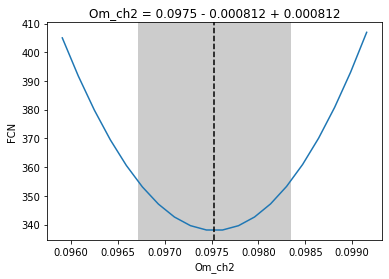

In [71]:
mtot.draw_profile('Om_ch2', bound=2, size=20)

/home/yve/anaconda3/lib/python3.7/site-packages/pyccl/core.py:678: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  category=CCLWarning)


(0.09753088855840251, 4.010258709845561) -> 406.2274249958805
(0.09753088855840251, 4.014150188412119) -> 392.82365840982635
(0.09753088855840251, 4.018041666978677) -> 380.83636652570374
(0.09753088855840251, 4.021933145545234) -> 370.28343994651016
(0.09753088855840251, 4.025824624111792) -> 361.1821467003204
(0.09753088855840251, 4.029716102678349) -> 353.55201794952984
(0.09753088855840251, 4.033607581244907) -> 347.40939165079305
(0.09753088855840251, 4.037499059811465) -> 342.7736064764876
(0.09753088855840251, 4.041390538378022) -> 339.6630414742422
(0.09753088855840251, 4.045282016944579) -> 338.09572874151263
(0.09753088855840251, 4.049173495511138) -> 338.09157317702886
(0.09753088855840251, 4.053064974077695) -> 339.6688583566267
(0.09753088855840251, 4.056956452644252) -> 342.8468299996283
(0.09753088855840251, 4.06084793121081) -> 347.6448833832277
(0.09753088855840251, 4.064739409777368) -> 354.0821606575514
(0.09753088855840251, 4.068630888343925) -> 362.17857314379046
(

(array([4.01025871, 4.01415019, 4.01804167, 4.02193315, 4.02582462,
        4.0297161 , 4.03360758, 4.03749906, 4.04139054, 4.04528202,
        4.0491735 , 4.05306497, 4.05695645, 4.06084793, 4.06473941,
        4.06863089, 4.07252237, 4.07641385, 4.08030532, 4.0841968 ]),
 array([406.227425  , 392.82365841, 380.83636653, 370.28343995,
        361.1821467 , 353.55201795, 347.40939165, 342.77360648,
        339.66304147, 338.09572874, 338.09157318, 339.66885836,
        342.84683   , 347.64488338, 354.08216066, 362.17857314,
        371.95368987, 383.42753599, 396.62021582, 411.55160666]))

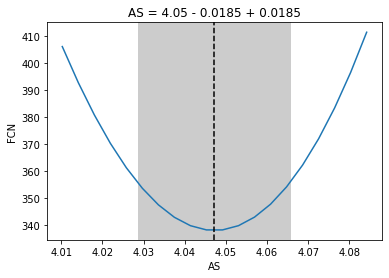

In [72]:
mtot.draw_profile('AS', bound=2, size=20)

/home/yve/anaconda3/lib/python3.7/site-packages/pyccl/core.py:678: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  category=CCLWarning)


(0.09590694302166805, 4.010258709845561) -> 598.2271600939199
(0.09590694302166805, 4.018474053486072) -> 545.0543615784838
(0.09590694302166805, 4.0266893971265825) -> 497.59854602853443
(0.09590694302166805, 4.034904740767093) -> 456.0171122562009
(0.09590694302166805, 4.043120084407604) -> 420.47055735627106
(0.09590694302166805, 4.051335428048113) -> 391.12161716171175
(0.09590694302166805, 4.059550771688624) -> 368.1364802399809
(0.09590694302166805, 4.0677661153291345) -> 351.68566943734487
(0.09590694302166805, 4.075981458969645) -> 341.9411272550585
(0.09590694302166805, 4.084196802610156) -> 339.0790094798466
(0.09626781980760904, 4.010258709845561) -> 545.0814658468042
(0.09626781980760904, 4.018474053486072) -> 497.596252578252
(0.09626781980760904, 4.0266893971265825) -> 455.9773144610356
(0.09626781980760904, 4.034904740767093) -> 420.3836386064679
(0.09626781980760904, 4.043120084407604) -> 390.9777762619007
(0.09626781980760904, 4.051335428048113) -> 367.92857269235543
(

(array([0.09590694, 0.09626782, 0.0966287 , 0.09698957, 0.09735045,
        0.09771133, 0.0980722 , 0.09843308, 0.09879396, 0.09915483]),
 array([4.01025871, 4.01847405, 4.0266894 , 4.03490474, 4.04312008,
        4.05133543, 4.05955077, 4.06776612, 4.07598146, 4.0841968 ]),
 array([[2.60317461e+02, 2.07144663e+02, 1.59688847e+02, 1.18107413e+02,
         8.25608583e+01, 5.32119181e+01, 3.02267812e+01, 1.37759704e+01,
         4.03142820e+00, 1.16931043e+00],
        [2.07171767e+02, 1.59686554e+02, 1.18067615e+02, 8.24739396e+01,
         5.30680772e+01, 3.00188736e+01, 1.34937368e+01, 3.66465895e+00,
         7.07211846e-01, 4.79924874e+00],
        [1.59958750e+02, 1.18279299e+02, 8.26171180e+01, 5.31345946e+01,
         2.99976992e+01, 1.33746510e+01, 3.43670518e+00, 3.59004520e-01,
         4.31947443e+00, 1.54990061e+01],
        [1.18742835e+02, 8.29916009e+01, 5.34080468e+01, 3.01607798e+01,
         1.34173124e+01, 3.34687531e+00, 1.24824556e-01, 3.92883607e+00,
         1.493

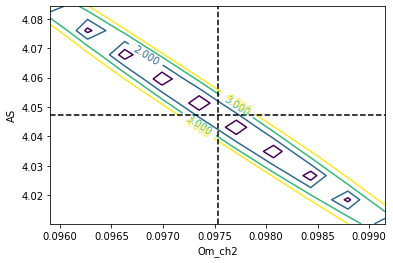

In [73]:
mtot.draw_contour('Om_ch2', 'AS', size=10)